## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


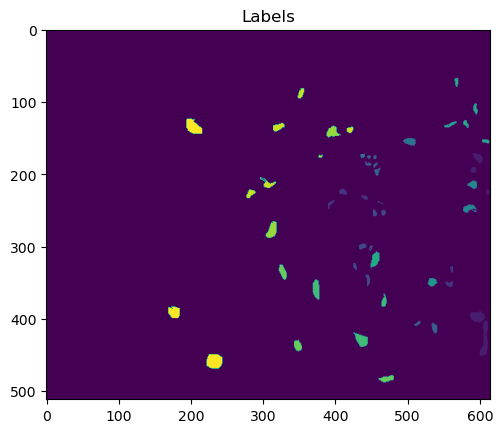

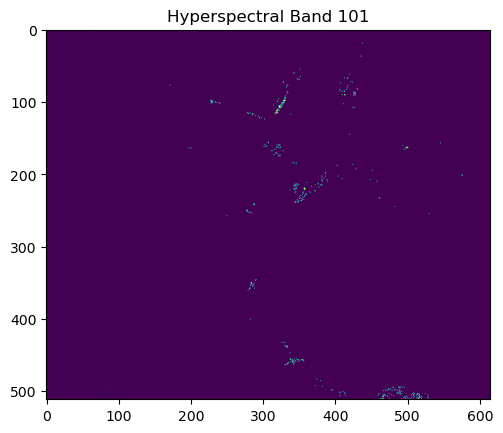

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(130, 5, 5, 176)
(65, 5, 5, 176)
(5016, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 130
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2498, PSNR: 6.0242


Epoch [1/50] Training Loss: 0.2379, PSNR: 6.2390
	[Val]   Batch [1/17] Loss: 0.2213, PSNR: 6.5495
	[Val]   Batch [10/17] Loss: 0.2219, PSNR: 6.5382
Epoch [1/50] Validation Loss: 0.2216, PSNR: 6.5434

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2166, PSNR: 6.6427


Epoch [2/50] Training Loss: 0.2015, PSNR: 6.9627
	[Val]   Batch [1/17] Loss: 0.1790, PSNR: 7.4707
	[Val]   Batch [10/17] Loss: 0.1811, PSNR: 7.4208
Epoch [2/50] Validation Loss: 0.1805, PSNR: 7.4356

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1797, PSNR: 7.4541


Epoch [3/50] Training Loss: 0.1659, PSNR: 7.8079
	[Val]   Batch [1/17] Loss: 0.1438, PSNR: 8.4216
	[Val]   Batch [10/17] Loss: 0.1461, PSNR: 8.3543
Epoch [3/50] Validation Loss: 0.1454, PSNR: 8.3731

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1458, PSNR: 8.3621


Epoch [4/50] Training Loss: 0.1342, PSNR: 8.7294
	[Val]   Batch [1/17] Loss: 0.1167, PSNR: 9.3275
	[Val]   Batch [10/17] Loss: 0.1184, PSNR: 9.2669
Epoch [4/50] Validation Loss: 0.1177, PSNR: 9.2934

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1173, PSNR: 9.3073


Epoch [5/50] Training Loss: 0.1076, PSNR: 9.6887
	[Val]   Batch [1/17] Loss: 0.0939, PSNR: 10.2748
	[Val]   Batch [10/17] Loss: 0.0955, PSNR: 10.1988
Epoch [5/50] Validation Loss: 0.0948, PSNR: 10.2329

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0941, PSNR: 10.2633


Epoch [6/50] Training Loss: 0.0864, PSNR: 10.6408
	[Val]   Batch [1/17] Loss: 0.0761, PSNR: 11.1878
	[Val]   Batch [10/17] Loss: 0.0774, PSNR: 11.1152
Epoch [6/50] Validation Loss: 0.0768, PSNR: 11.1492

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0757, PSNR: 11.2110


Epoch [7/50] Training Loss: 0.0699, PSNR: 11.5588
	[Val]   Batch [1/17] Loss: 0.0618, PSNR: 12.0871
	[Val]   Batch [10/17] Loss: 0.0625, PSNR: 12.0443
Epoch [7/50] Validation Loss: 0.0621, PSNR: 12.0695

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0618, PSNR: 12.0875


Epoch [8/50] Training Loss: 0.0573, PSNR: 12.4227
	[Val]   Batch [1/17] Loss: 0.0519, PSNR: 12.8511
	[Val]   Batch [10/17] Loss: 0.0526, PSNR: 12.7941
Epoch [8/50] Validation Loss: 0.0522, PSNR: 12.8260

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0512, PSNR: 12.9067


Epoch [9/50] Training Loss: 0.0477, PSNR: 13.2218
	[Val]   Batch [1/17] Loss: 0.0435, PSNR: 13.6173
	[Val]   Batch [10/17] Loss: 0.0440, PSNR: 13.5614
Epoch [9/50] Validation Loss: 0.0437, PSNR: 13.5910

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0431, PSNR: 13.6532


Epoch [10/50] Training Loss: 0.0402, PSNR: 13.9602
	[Val]   Batch [1/17] Loss: 0.0369, PSNR: 14.3258
	[Val]   Batch [10/17] Loss: 0.0373, PSNR: 14.2795
Epoch [10/50] Validation Loss: 0.0371, PSNR: 14.3046

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0366, PSNR: 14.3625


Epoch [11/50] Training Loss: 0.0345, PSNR: 14.6300
	[Val]   Batch [1/17] Loss: 0.0323, PSNR: 14.9142
	[Val]   Batch [10/17] Loss: 0.0327, PSNR: 14.8551
Epoch [11/50] Validation Loss: 0.0325, PSNR: 14.8850

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0314, PSNR: 15.0372


Epoch [12/50] Training Loss: 0.0299, PSNR: 14.5661
	[Val]   Batch [1/17] Loss: 0.0281, PSNR: 15.5127
	[Val]   Batch [10/17] Loss: 0.0285, PSNR: 15.4580
Epoch [12/50] Validation Loss: 0.0283, PSNR: 15.4862

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0275, PSNR: 15.6009


Epoch [13/50] Training Loss: 0.0262, PSNR: 15.1311
	[Val]   Batch [1/17] Loss: 0.0250, PSNR: 16.0130
	[Val]   Batch [10/17] Loss: 0.0255, PSNR: 15.9318
Epoch [13/50] Validation Loss: 0.0253, PSNR: 15.9716

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0240, PSNR: 16.1889


Epoch [14/50] Training Loss: 0.0232, PSNR: 15.6573
	[Val]   Batch [1/17] Loss: 0.0224, PSNR: 16.4913
	[Val]   Batch [10/17] Loss: 0.0228, PSNR: 16.4239
Epoch [14/50] Validation Loss: 0.0226, PSNR: 16.4562

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0218, PSNR: 16.6236


Epoch [15/50] Training Loss: 0.0208, PSNR: 16.8216
	[Val]   Batch [1/17] Loss: 0.0201, PSNR: 16.9679
	[Val]   Batch [10/17] Loss: 0.0204, PSNR: 16.9096
Epoch [15/50] Validation Loss: 0.0203, PSNR: 16.9346

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0196, PSNR: 17.0777


Epoch [16/50] Training Loss: 0.0187, PSNR: 17.2869
	[Val]   Batch [1/17] Loss: 0.0180, PSNR: 17.4497
	[Val]   Batch [10/17] Loss: 0.0183, PSNR: 17.3859
Epoch [16/50] Validation Loss: 0.0181, PSNR: 17.4144

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0177, PSNR: 17.5230


Epoch [17/50] Training Loss: 0.0170, PSNR: 17.7094
	[Val]   Batch [1/17] Loss: 0.0164, PSNR: 17.8520
	[Val]   Batch [10/17] Loss: 0.0166, PSNR: 17.7998
Epoch [17/50] Validation Loss: 0.0165, PSNR: 17.8264

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0161, PSNR: 17.9219


Epoch [18/50] Training Loss: 0.0154, PSNR: 17.4337
	[Val]   Batch [1/17] Loss: 0.0152, PSNR: 18.1917
	[Val]   Batch [10/17] Loss: 0.0154, PSNR: 18.1136
Epoch [18/50] Validation Loss: 0.0153, PSNR: 18.1483

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0146, PSNR: 18.3558


Epoch [19/50] Training Loss: 0.0141, PSNR: 17.8164
	[Val]   Batch [1/17] Loss: 0.0138, PSNR: 18.5949
	[Val]   Batch [10/17] Loss: 0.0141, PSNR: 18.5113
Epoch [19/50] Validation Loss: 0.0140, PSNR: 18.5509

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0133, PSNR: 18.7537


Epoch [20/50] Training Loss: 0.0130, PSNR: 18.8536
	[Val]   Batch [1/17] Loss: 0.0127, PSNR: 18.9610
	[Val]   Batch [10/17] Loss: 0.0129, PSNR: 18.8902
Epoch [20/50] Validation Loss: 0.0128, PSNR: 18.9240

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0123, PSNR: 19.0955


Epoch [21/50] Training Loss: 0.0120, PSNR: 19.2060
	[Val]   Batch [1/17] Loss: 0.0118, PSNR: 19.2751
	[Val]   Batch [10/17] Loss: 0.0120, PSNR: 19.2001
Epoch [21/50] Validation Loss: 0.0119, PSNR: 19.2351

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0114, PSNR: 19.4427


Epoch [22/50] Training Loss: 0.0111, PSNR: 19.5413
	[Val]   Batch [1/17] Loss: 0.0109, PSNR: 19.6365
	[Val]   Batch [10/17] Loss: 0.0111, PSNR: 19.5536
Epoch [22/50] Validation Loss: 0.0110, PSNR: 19.5967

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0106, PSNR: 19.7537


Epoch [23/50] Training Loss: 0.0103, PSNR: 19.1732
	[Val]   Batch [1/17] Loss: 0.0102, PSNR: 19.9205
	[Val]   Batch [10/17] Loss: 0.0104, PSNR: 19.8273
Epoch [23/50] Validation Loss: 0.0103, PSNR: 19.8753

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0098, PSNR: 20.0762


Epoch [24/50] Training Loss: 0.0096, PSNR: 20.1635
	[Val]   Batch [1/17] Loss: 0.0096, PSNR: 20.1930
	[Val]   Batch [10/17] Loss: 0.0098, PSNR: 20.1040
Epoch [24/50] Validation Loss: 0.0097, PSNR: 20.1500

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0097, PSNR: 20.1442


Epoch [25/50] Training Loss: 0.0090, PSNR: 20.4578
	[Val]   Batch [1/17] Loss: 0.0089, PSNR: 20.5296
	[Val]   Batch [10/17] Loss: 0.0091, PSNR: 20.4331
Epoch [25/50] Validation Loss: 0.0090, PSNR: 20.4797

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0087, PSNR: 20.5848


Epoch [26/50] Training Loss: 0.0084, PSNR: 20.0573
	[Val]   Batch [1/17] Loss: 0.0084, PSNR: 20.7809
	[Val]   Batch [10/17] Loss: 0.0086, PSNR: 20.6711
Epoch [26/50] Validation Loss: 0.0085, PSNR: 20.7224

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0081, PSNR: 20.9080


Epoch [27/50] Training Loss: 0.0079, PSNR: 21.0033
	[Val]   Batch [1/17] Loss: 0.0078, PSNR: 21.0759
	[Val]   Batch [10/17] Loss: 0.0080, PSNR: 20.9709
Epoch [27/50] Validation Loss: 0.0079, PSNR: 21.0197

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0077, PSNR: 21.1563


Epoch [28/50] Training Loss: 0.0075, PSNR: 20.5761
	[Val]   Batch [1/17] Loss: 0.0074, PSNR: 21.3250
	[Val]   Batch [10/17] Loss: 0.0076, PSNR: 21.2034
Epoch [28/50] Validation Loss: 0.0075, PSNR: 21.2634

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0073, PSNR: 21.3804


Epoch [29/50] Training Loss: 0.0071, PSNR: 21.5189
	[Val]   Batch [1/17] Loss: 0.0070, PSNR: 21.5464
	[Val]   Batch [10/17] Loss: 0.0072, PSNR: 21.4300
Epoch [29/50] Validation Loss: 0.0071, PSNR: 21.4863

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0068, PSNR: 21.6714


Epoch [30/50] Training Loss: 0.0067, PSNR: 21.7651
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8567
	[Val]   Batch [10/17] Loss: 0.0067, PSNR: 21.7260
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.7875

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0076


Epoch [31/50] Training Loss: 0.0063, PSNR: 21.3349
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 22.0178
	[Val]   Batch [10/17] Loss: 0.0065, PSNR: 21.8884
Epoch [31/50] Validation Loss: 0.0064, PSNR: 21.9510

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0061, PSNR: 22.1818


Epoch [32/50] Training Loss: 0.0060, PSNR: 22.2279
	[Val]   Batch [1/17] Loss: 0.0059, PSNR: 22.2611
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1242
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.1894

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4464


Epoch [33/50] Training Loss: 0.0057, PSNR: 22.4498
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.4905
	[Val]   Batch [10/17] Loss: 0.0058, PSNR: 22.3528
Epoch [33/50] Validation Loss: 0.0057, PSNR: 22.4153

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.6783


Epoch [34/50] Training Loss: 0.0054, PSNR: 22.6720
	[Val]   Batch [1/17] Loss: 0.0054, PSNR: 22.6778
	[Val]   Batch [10/17] Loss: 0.0056, PSNR: 22.5393
Epoch [34/50] Validation Loss: 0.0055, PSNR: 22.6036

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0053, PSNR: 22.7730


Epoch [35/50] Training Loss: 0.0052, PSNR: 22.8779
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9224
	[Val]   Batch [10/17] Loss: 0.0053, PSNR: 22.7715
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8407

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0051, PSNR: 22.9218


Epoch [36/50] Training Loss: 0.0049, PSNR: 23.0792
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.0744
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.9172
Epoch [36/50] Validation Loss: 0.0050, PSNR: 22.9866

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2419


Epoch [37/50] Training Loss: 0.0047, PSNR: 23.2826
	[Val]   Batch [1/17] Loss: 0.0047, PSNR: 23.3153
	[Val]   Batch [10/17] Loss: 0.0048, PSNR: 23.1511
Epoch [37/50] Validation Loss: 0.0048, PSNR: 23.2255

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.4331


Epoch [38/50] Training Loss: 0.0045, PSNR: 23.4775
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5434
	[Val]   Batch [10/17] Loss: 0.0046, PSNR: 23.3711
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4500

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0045, PSNR: 23.5070


Epoch [39/50] Training Loss: 0.0043, PSNR: 23.6804
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7308
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5503
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6302

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7700


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.8584
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.8921
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.7065
Epoch [40/50] Validation Loss: 0.0042, PSNR: 23.7887

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9450


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0376
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1351
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9440
Epoch [41/50] Validation Loss: 0.0040, PSNR: 24.0277

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0038, PSNR: 24.1997


Epoch [42/50] Training Loss: 0.0038, PSNR: 24.2103
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.2598
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.0641
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.1478

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4658


Epoch [43/50] Training Loss: 0.0036, PSNR: 24.3935
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4175
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2212
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.3061

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6859


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.5557
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.6128
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4108
Epoch [44/50] Validation Loss: 0.0036, PSNR: 24.4979

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.6706


Epoch [45/50] Training Loss: 0.0034, PSNR: 24.7196
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7782
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5696
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.6579

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0033, PSNR: 24.8638


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.2053
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9317
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.7053
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8034

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9573


Epoch [47/50] Training Loss: 0.0031, PSNR: 24.3737
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1013
	[Val]   Batch [10/17] Loss: 0.0033, PSNR: 24.8692
Epoch [47/50] Validation Loss: 0.0032, PSNR: 24.9689

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.3784


Epoch [48/50] Training Loss: 0.0030, PSNR: 25.2133
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.3015
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0671
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.1669

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.1688


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3561
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.4356
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2002
Epoch [49/50] Validation Loss: 0.0030, PSNR: 25.3005

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5299


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5041
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5664
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3285
Epoch [50/50] Validation Loss: 0.0029, PSNR: 25.4298


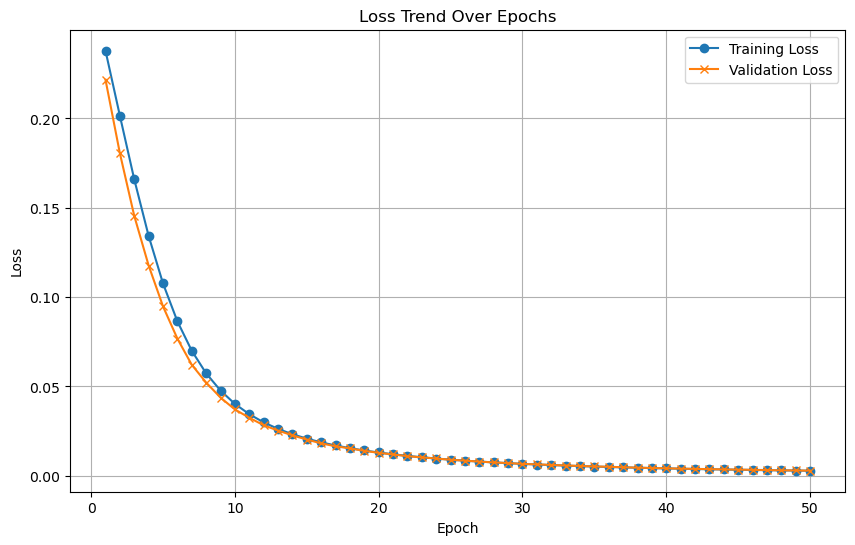

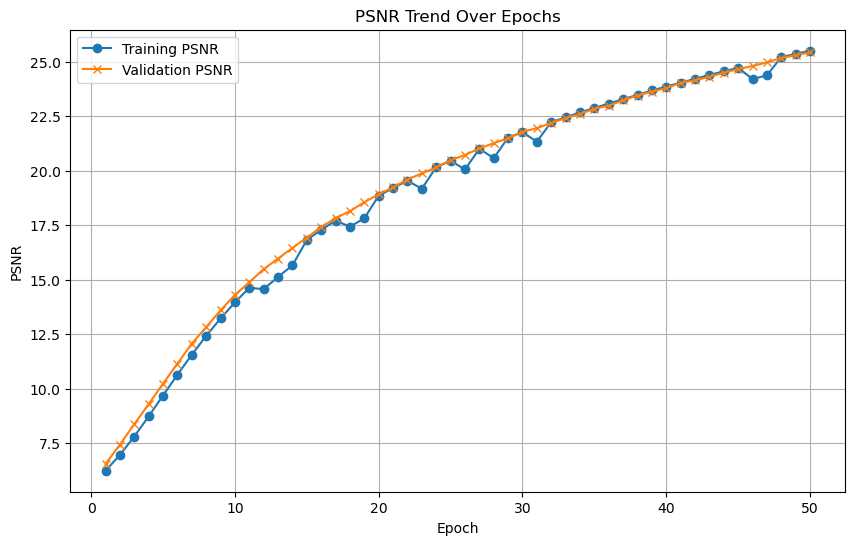

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5808
    Validation Batch [1/1], Loss: 2.5694
Validation Loss: 2.5694, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5694. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5604
    Validation Batch [1/1], Loss: 2.5694
Validation Loss: 2.5694, Validation Accuracy: 7.69%
Validation loss improved from 2.5694 to 2.5694. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5543
    Validation Batch [1/1], Loss: 2.5694
Validation Loss: 2.5694, Validation Accuracy: 7.69%
Validation loss improved from 2.5694 to 2.5694. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5451
    Validation Batch [1/1], Loss: 2.5694
Validation Loss: 2.5694, Validation Accuracy: 7.69%
Validation loss improved from 2.5694 to 2.5694. Saving model...

LOG: Epoch [5/1000] - 

Epoch [20/1000] completed, Average Training Loss: 2.4626
    Validation Batch [1/1], Loss: 2.5690
Validation Loss: 2.5690, Validation Accuracy: 7.69%
Validation loss improved from 2.5691 to 2.5690. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4446
    Validation Batch [1/1], Loss: 2.5688
Validation Loss: 2.5688, Validation Accuracy: 7.69%
Validation loss improved from 2.5690 to 2.5688. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4450
    Validation Batch [1/1], Loss: 2.5686
Validation Loss: 2.5686, Validation Accuracy: 7.69%
Validation loss improved from 2.5688 to 2.5686. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4235
    Validation Batch [1/1], Loss: 2.5684
Validation Loss: 2.5684, Validation Accuracy: 7.69%
Validation loss improved from 2.5686 to 2.5684. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/10

    Validation Batch [1/1], Loss: 2.5470
Validation Loss: 2.5470, Validation Accuracy: 15.38%
Validation loss improved from 2.5495 to 2.5470. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.2017
    Validation Batch [1/1], Loss: 2.5444
Validation Loss: 2.5444, Validation Accuracy: 15.38%
Validation loss improved from 2.5470 to 2.5444. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.1825
    Validation Batch [1/1], Loss: 2.5416
Validation Loss: 2.5416, Validation Accuracy: 16.92%
Validation loss improved from 2.5444 to 2.5416. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.2037
    Validation Batch [1/1], Loss: 2.5386
Validation Loss: 2.5386, Validation Accuracy: 16.92%
Validation loss improved from 2.5416 to 2.5386. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.1870
    Vali

Epoch [76/1000] completed, Average Training Loss: 2.0415
    Validation Batch [1/1], Loss: 2.3791
Validation Loss: 2.3791, Validation Accuracy: 24.62%
Validation loss improved from 2.3918 to 2.3791. Saving model...

LOG: Epoch [77/1000] - Training
Epoch [77/1000] completed, Average Training Loss: 2.0117
    Validation Batch [1/1], Loss: 2.3659
Validation Loss: 2.3659, Validation Accuracy: 26.15%
Validation loss improved from 2.3791 to 2.3659. Saving model...

LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 2.0168
    Validation Batch [1/1], Loss: 2.3528
Validation Loss: 2.3528, Validation Accuracy: 26.15%
Validation loss improved from 2.3659 to 2.3528. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.9893
    Validation Batch [1/1], Loss: 2.3394
Validation Loss: 2.3394, Validation Accuracy: 30.77%
Validation loss improved from 2.3528 to 2.3394. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [8

Epoch [100/1000] completed, Average Training Loss: 1.8580
    Validation Batch [1/1], Loss: 2.0383
Validation Loss: 2.0383, Validation Accuracy: 46.15%
Validation loss improved from 2.0484 to 2.0383. Saving model...

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.8134
    Validation Batch [1/1], Loss: 2.0292
Validation Loss: 2.0292, Validation Accuracy: 46.15%
Validation loss improved from 2.0383 to 2.0292. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.8281
    Validation Batch [1/1], Loss: 2.0205
Validation Loss: 2.0205, Validation Accuracy: 46.15%
Validation loss improved from 2.0292 to 2.0205. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.8364
    Validation Batch [1/1], Loss: 2.0114
Validation Loss: 2.0114, Validation Accuracy: 46.15%
Validation loss improved from 2.0205 to 2.0114. Saving model...

LOG: Epoch [104/1000] - Training


Epoch [124/1000] completed, Average Training Loss: 1.6461
    Validation Batch [1/1], Loss: 1.8490
Validation Loss: 1.8490, Validation Accuracy: 53.85%
Validation loss improved from 1.8535 to 1.8490. Saving model...

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.6421
    Validation Batch [1/1], Loss: 1.8437
Validation Loss: 1.8437, Validation Accuracy: 53.85%
Validation loss improved from 1.8490 to 1.8437. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.6374
    Validation Batch [1/1], Loss: 1.8384
Validation Loss: 1.8384, Validation Accuracy: 52.31%
Validation loss improved from 1.8437 to 1.8384. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.6260
    Validation Batch [1/1], Loss: 1.8314
Validation Loss: 1.8314, Validation Accuracy: 56.92%
Validation loss improved from 1.8384 to 1.8314. Saving model...

LOG: Epoch [128/1000] - Training


    Validation Batch [1/1], Loss: 1.6626
Validation Loss: 1.6626, Validation Accuracy: 58.46%
Validation loss improved from 1.6705 to 1.6626. Saving model...

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 1.4442
    Validation Batch [1/1], Loss: 1.6579
Validation Loss: 1.6579, Validation Accuracy: 60.00%
Validation loss improved from 1.6626 to 1.6579. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.4352
    Validation Batch [1/1], Loss: 1.6516
Validation Loss: 1.6516, Validation Accuracy: 60.00%
Validation loss improved from 1.6579 to 1.6516. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.4220
    Validation Batch [1/1], Loss: 1.6439
Validation Loss: 1.6439, Validation Accuracy: 56.92%
Validation loss improved from 1.6516 to 1.6439. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.3810


Epoch [182/1000] completed, Average Training Loss: 1.2135
    Validation Batch [1/1], Loss: 1.5076
Validation Loss: 1.5076, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.1744
    Validation Batch [1/1], Loss: 1.4992
Validation Loss: 1.4992, Validation Accuracy: 63.08%
Validation loss improved from 1.5074 to 1.4992. Saving model...

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 1.1846
    Validation Batch [1/1], Loss: 1.4879
Validation Loss: 1.4879, Validation Accuracy: 60.00%
Validation loss improved from 1.4992 to 1.4879. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 1.1155
    Validation Batch [1/1], Loss: 1.4814
Validation Loss: 1.4814, Validation Accuracy: 63.08%
Validation loss improved from 1.4879 to 1.4814. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000

Epoch [210/1000] completed, Average Training Loss: 0.9239
    Validation Batch [1/1], Loss: 1.4123
Validation Loss: 1.4123, Validation Accuracy: 73.85%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.8999
    Validation Batch [1/1], Loss: 1.4122
Validation Loss: 1.4122, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.8942
    Validation Batch [1/1], Loss: 1.3983
Validation Loss: 1.3983, Validation Accuracy: 76.92%
Validation loss improved from 1.4045 to 1.3983. Saving model...

LOG: Epoch [213/1000] - Training
Epoch [213/1000] completed, Average Training Loss: 0.8983
    Validation Batch [1/1], Loss: 1.3840
Validation Loss: 1.3840, Validation Accuracy: 76.92%
Validation loss improved from 1.3983 to 1.3840. Saving model...

LOG: Epoch [214/1000] - Training
Epoch [214/1000] completed, Av

    Validation Batch [1/1], Loss: 1.3641
Validation Loss: 1.3641, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [241/1000] - Training
Epoch [241/1000] completed, Average Training Loss: 0.6269
    Validation Batch [1/1], Loss: 1.3493
Validation Loss: 1.3493, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.6633
    Validation Batch [1/1], Loss: 1.3400
Validation Loss: 1.3400, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.6302
    Validation Batch [1/1], Loss: 1.3328
Validation Loss: 1.3328, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.6538
    Validation Batch [1/1], Loss: 1.3311
Validation Loss: 1

Epoch [268/1000] completed, Average Training Loss: 0.5017
    Validation Batch [1/1], Loss: 1.3037
Validation Loss: 1.3037, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.4527
    Validation Batch [1/1], Loss: 1.3210
Validation Loss: 1.3210, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4054
    Validation Batch [1/1], Loss: 1.3227
Validation Loss: 1.3227, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.4460
    Validation Batch [1/1], Loss: 1.2972
Validation Loss: 1.2972, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.4381
  

Epoch [299/1000] completed, Average Training Loss: 0.3376
    Validation Batch [1/1], Loss: 1.2620
Validation Loss: 1.2620, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.3238
    Validation Batch [1/1], Loss: 1.2608
Validation Loss: 1.2608, Validation Accuracy: 69.23%
Validation loss improved from 1.2616 to 1.2608. Saving model...

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.3148
    Validation Batch [1/1], Loss: 1.2695
Validation Loss: 1.2695, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.3107
    Validation Batch [1/1], Loss: 1.2774
Validation Loss: 1.2774, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.2853
Validation Loss: 1.2853, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [329/1000] - Training
Epoch [329/1000] completed, Average Training Loss: 0.2498
    Validation Batch [1/1], Loss: 1.2812
Validation Loss: 1.2812, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [330/1000] - Training
Epoch [330/1000] completed, Average Training Loss: 0.2347
    Validation Batch [1/1], Loss: 1.2842
Validation Loss: 1.2842, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.2266
    Validation Batch [1/1], Loss: 1.2844
Validation Loss: 1.2844, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.2161
    Validation Batch [1/1], Loss: 1.2814
Validation Loss

Epoch [357/1000] completed, Average Training Loss: 0.1864
    Validation Batch [1/1], Loss: 1.3301
Validation Loss: 1.3301, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [358/1000] - Training
Epoch [358/1000] completed, Average Training Loss: 0.1999
    Validation Batch [1/1], Loss: 1.3113
Validation Loss: 1.3113, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [359/1000] - Training
Epoch [359/1000] completed, Average Training Loss: 0.1981
    Validation Batch [1/1], Loss: 1.3040
Validation Loss: 1.3040, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [360/1000] - Training
Epoch [360/1000] completed, Average Training Loss: 0.1564
    Validation Batch [1/1], Loss: 1.2980
Validation Loss: 1.2980, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [361/1000] - Training
Epoch [361/1000] completed, Average Training Loss: 0.199

Epoch [386/1000] completed, Average Training Loss: 0.1641
    Validation Batch [1/1], Loss: 1.2979
Validation Loss: 1.2979, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [387/1000] - Training
Epoch [387/1000] completed, Average Training Loss: 0.1563
    Validation Batch [1/1], Loss: 1.3091
Validation Loss: 1.3091, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1613
    Validation Batch [1/1], Loss: 1.3176
Validation Loss: 1.3176, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1536
    Validation Batch [1/1], Loss: 1.3112
Validation Loss: 1.3112, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.133

Epoch [414/1000] completed, Average Training Loss: 0.1186
    Validation Batch [1/1], Loss: 1.3183
Validation Loss: 1.3183, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [415/1000] - Training
Epoch [415/1000] completed, Average Training Loss: 0.1156
    Validation Batch [1/1], Loss: 1.3395
Validation Loss: 1.3395, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [416/1000] - Training
Epoch [416/1000] completed, Average Training Loss: 0.1382
    Validation Batch [1/1], Loss: 1.3520
Validation Loss: 1.3520, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [417/1000] - Training
Epoch [417/1000] completed, Average Training Loss: 0.1089
    Validation Batch [1/1], Loss: 1.3587
Validation Loss: 1.3587, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [418/1000] - Training
Epoch [418/1000] completed, Average Training Loss: 0.137

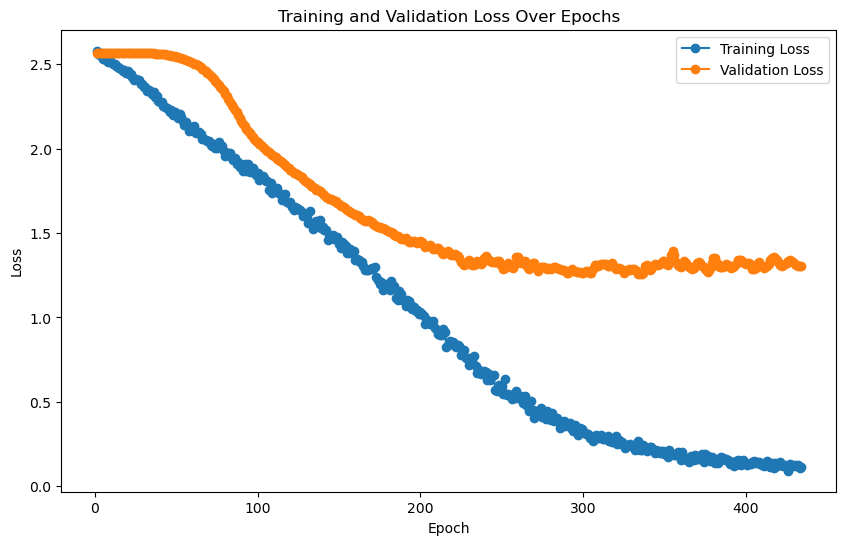

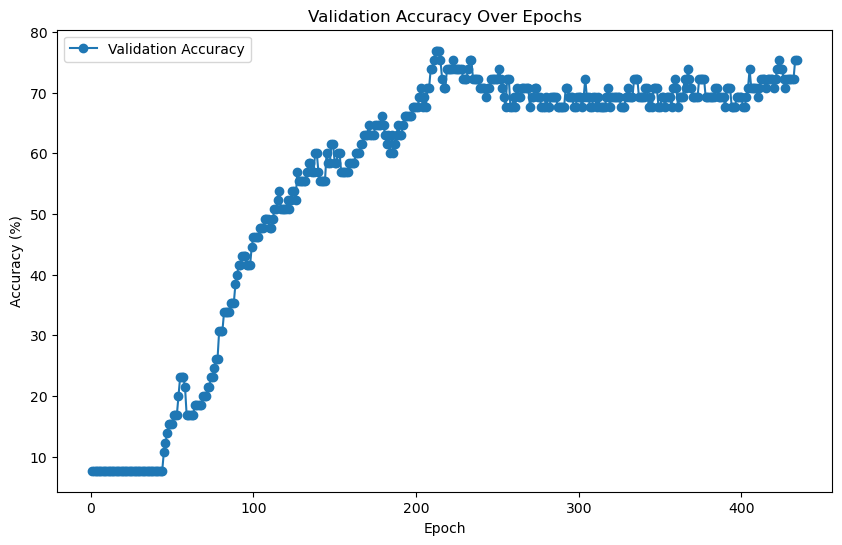


Evaluating on the test set...
    Test Batch [1/20], Loss: 1.0668

Final Test Loss: 1.0812, Test Accuracy: 75.24%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)

LOG: Training features shape: (130, 64), Training labels shape: (130,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5016, 64), Test labels shape: (5016,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 33.85%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.12      0.20      0.15         5
           1       0.00      0.00      0.00         5
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00         5
           4       0.80      0.80      0.80         5
           5       0.18      0.60      0.27         5
           6       0.00      0.00      0.00         5
           7       0.27      0.60      0.38         5
           8       0.40      0.80  

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)
Train reps shape: (130, 64)
Train labels shape: (130,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5016, 64)
Test labels shape: (5016,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6078  |  Val Loss: 2.5179
Validation loss improved from inf to 2.5179.
[Epoch 2/1000] Train Loss: 2.5268  |  Val Loss: 2.4907
Validation loss improved from 2.5179 to 2.4907.
[Epoch 3/1000] Train Loss: 2.5017  |  Val Loss: 2.4768
Validation loss improved from 2.4907 to 2.4768.
[Epoch 4/1000] Train Loss: 2.4910  |  Val Loss: 2.4711
Validation loss improved from 2.4768 to 2.4711.
[Epoch 5/1000] Train Loss: 2.4780  |  Val Loss: 2.4729
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 6/1000] Train Loss: 2.4755  |  Val Loss: 2.4734
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 7/1000] Train Loss: 2.4667  |  Val Loss: 2.4657
Validation loss improved from 2.4711 to 2.4657.
[Epoch 8/1000] Train Loss: 2.4532  |  Val Loss: 2.4550
Validation loss improved from 2.4657 to 2.4550.
[Epoch 9/1000] Train Loss: 2.4378  |  Val Loss: 2.4479
Validation loss improved from 2.4550 to 2.4479.
[Epoch 10/1000] Train Loss: 2.4302  |  Val Loss: 2.4478
Validati

[Epoch 20/1000] Train Loss: 2.3903  |  Val Loss: 2.4467
Validation loss improved from 2.4478 to 2.4467.
[Epoch 21/1000] Train Loss: 2.3874  |  Val Loss: 2.4430
Validation loss improved from 2.4467 to 2.4430.
[Epoch 22/1000] Train Loss: 2.3918  |  Val Loss: 2.4463
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 23/1000] Train Loss: 2.4158  |  Val Loss: 2.4533
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 24/1000] Train Loss: 2.4138  |  Val Loss: 2.4404
Validation loss improved from 2.4430 to 2.4404.
[Epoch 25/1000] Train Loss: 2.3841  |  Val Loss: 2.4391
Validation loss improved from 2.4404 to 2.4391.


[Epoch 26/1000] Train Loss: 2.3709  |  Val Loss: 2.4538
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 2.3714  |  Val Loss: 2.4588
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 28/1000] Train Loss: 2.3719  |  Val Loss: 2.4624
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 29/1000] Train Loss: 2.3729  |  Val Loss: 2.4663
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 30/1000] Train Loss: 2.3779  |  Val Loss: 2.4768
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 31/1000] Train Loss: 2.3836  |  Val Loss: 2.4807
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 32/1000] Train Loss: 2.3851  |  Val Loss: 2.4724
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 33/1000] Train Loss: 2.3750  |  Val Loss: 2.4556
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 34/1000] Train Loss: 2.3614  |  Val Loss: 2.4439
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 35/

[Epoch 54/1000] Train Loss: 2.3337  |  Val Loss: 2.5017
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 55/1000] Train Loss: 2.3401  |  Val Loss: 2.5125
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 56/1000] Train Loss: 2.3393  |  Val Loss: 2.5051
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 57/1000] Train Loss: 2.3364  |  Val Loss: 2.4926
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 58/1000] Train Loss: 2.3279  |  Val Loss: 2.4813
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 59/1000] Train Loss: 2.3200  |  Val Loss: 2.4693
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 60/1000] Train Loss: 2.3125  |  Val Loss: 2.4370
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 61/1000] Train Loss: 2.3127  |  Val Loss: 2.4145
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 62/1000] Train Loss: 2.3193  |  Val Loss: 2.4152
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 63/1000] Train Loss: 2.3442  |  Val Loss: 2.4428
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 64/1000] Train Loss: 2.3719  |  Val Loss: 2.4561
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 65/1000] Train Loss: 2.3780  |  Val Loss: 2.4466
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 66/1000] Train Loss: 2.3478  |  Val Loss: 2.4300
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 67/1000] Train Loss: 2.3261  |  Val Loss: 2.4375
!! Validation loss did NOT improve !! Patience: 20/100
[

[Epoch 84/1000] Train Loss: 2.2881  |  Val Loss: 2.4067
!! Validation loss did NOT improve !! Patience: 12/100


[Epoch 85/1000] Train Loss: 2.2947  |  Val Loss: 2.4138
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 86/1000] Train Loss: 2.3114  |  Val Loss: 2.4345
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 87/1000] Train Loss: 2.3269  |  Val Loss: 2.4531
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 88/1000] Train Loss: 2.3436  |  Val Loss: 2.4592
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 89/1000] Train Loss: 2.3400  |  Val Loss: 2.4446
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 90/1000] Train Loss: 2.3213  |  Val Loss: 2.4281
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 91/1000] Train Loss: 2.3104  |  Val Loss: 2.4204
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 92/1000] Train Loss: 2.3037  |  Val Loss: 2.4239
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 93/1000] Train Loss: 2.2965  |  Val Loss: 2.4358
!! Validation loss did NOT improve !! Patience: 21/100
[

[Epoch 115/1000] Train Loss: 2.2559  |  Val Loss: 2.4550
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 116/1000] Train Loss: 2.2581  |  Val Loss: 2.4460
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 117/1000] Train Loss: 2.2610  |  Val Loss: 2.4426
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 118/1000] Train Loss: 2.2666  |  Val Loss: 2.4393
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 119/1000] Train Loss: 2.2720  |  Val Loss: 2.4348
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 120/1000] Train Loss: 2.2666  |  Val Loss: 2.4328
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 121/1000] Train Loss: 2.2588  |  Val Loss: 2.4518
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 122/1000] Train Loss: 2.2535  |  Val Loss: 2.4728
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 123/1000] Train Loss: 2.2569  |  Val Loss: 2.4903
!! Validation loss did NOT improve !! Patience:

[Epoch 147/1000] Train Loss: 2.2469  |  Val Loss: 2.4854
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 148/1000] Train Loss: 2.2321  |  Val Loss: 2.4726
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 149/1000] Train Loss: 2.2126  |  Val Loss: 2.4568
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 150/1000] Train Loss: 2.2048  |  Val Loss: 2.4488
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 151/1000] Train Loss: 2.1979  |  Val Loss: 2.4596
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 152/1000] Train Loss: 2.2179  |  Val Loss: 2.4925
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 153/1000] Train Loss: 2.2257  |  Val Loss: 2.5260
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 154/1000] Train Loss: 2.2241  |  Val Loss: 2.5527
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 155/1000] Train Loss: 2.2473  |  Val Loss: 2.5307
!! Validation loss did NOT improve !! Patience:

[Epoch 178/1000] Train Loss: 2.1977  |  Val Loss: 2.4932
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 179/1000] Train Loss: 2.1910  |  Val Loss: 2.4706
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 180/1000] Train Loss: 2.1841  |  Val Loss: 2.4646
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 181/1000] Train Loss: 2.1726  |  Val Loss: 2.4671
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 182/1000] Train Loss: 2.1672  |  Val Loss: 2.4682
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 183/1000] Train Loss: 2.1602  |  Val Loss: 2.4617
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 184/1000] Train Loss: 2.1562  |  Val Loss: 2.4266
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 185/1000] Train Loss: 2.1675  |  Val Loss: 2.4016
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 186/1000] Train Loss: 2.1677  |  Val Loss: 2.4247
!! Validation loss did NOT improve !! Patience:

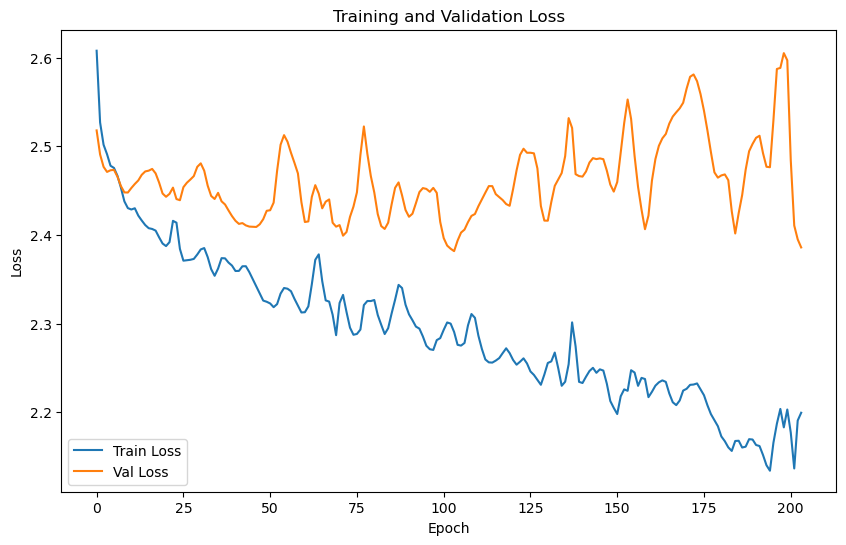

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.3848 | Test Accuracy: 19.24%


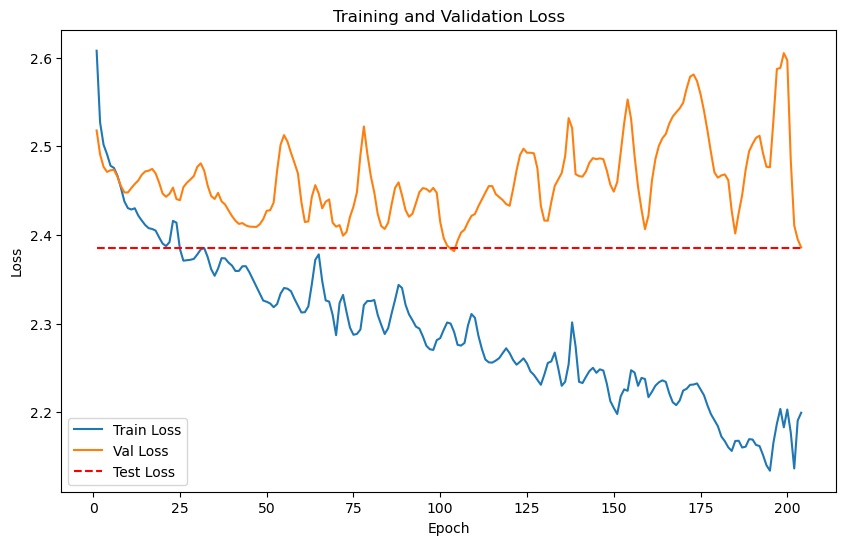

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.1826
Epoch [1/2000], Avg Train Loss: 8.1826
Epoch [1/2000], Avg Val Loss: 5.2883
Validation loss improved from inf to 5.2883. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.9131
Epoch [2/2000], Avg Train Loss: 7.9131
Epoch [2/2000], Avg Val Loss: 5.2605
Validation loss improved from 5.2883 to 5.2605. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.9229
Epoch [3/2000], Avg Train Loss: 7.9229
Epoch [3/2000], Avg Val Loss: 5.2332
Validation loss improved from 5.2605 to 5.2332. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.9552
Epoch [4/2000], Avg Train Loss: 7.9552
Epoch [4/2000], Avg Val Loss: 5.2068
Validation loss improved from 5.2332 to 5.2068. Saving model...

LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 7.6351
Epoch [5/2000], Avg Train Loss: 7.6351
Epoch [5/2000], Avg Val Loss: 5.1806
Validation loss improved from 5.2068 to 5.1806. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.6430
Epoch [6/2000], Avg Train Loss: 7.6430
Epoch [6/2000], Avg Val Loss: 5.1546
Validation loss improved from 5.1806 to 5.1546. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 7.5769
Epoch [7/2000], Avg Train Loss: 7.5769
Epoch [7/2000], Avg Val Loss: 5.1287
Validation loss improved from 5.1546 to 5.1287. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 7.5739
Epoch [8/2000], Avg Train Loss: 7.5739
Epoch [8/2000], Avg Val Loss: 5.1034
Validation loss improved from 5.1287 to 5.1034. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.4231
Epoch [9/2000], Avg Train Loss: 7.4231
Epoch [9/2000], Avg Val Loss: 5.0781
Validation loss improved from 5.1034 to 5.0781. Saving m

    Batch [1/1], Train Loss: 6.7734
Epoch [21/2000], Avg Train Loss: 6.7734
Epoch [21/2000], Avg Val Loss: 4.7839
Validation loss improved from 4.8073 to 4.7839. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.7100
Epoch [22/2000], Avg Train Loss: 6.7100
Epoch [22/2000], Avg Val Loss: 4.7607
Validation loss improved from 4.7839 to 4.7607. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.6430
Epoch [23/2000], Avg Train Loss: 6.6430
Epoch [23/2000], Avg Val Loss: 4.7379
Validation loss improved from 4.7607 to 4.7379. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.6434
Epoch [24/2000], Avg Train Loss: 6.6434
Epoch [24/2000], Avg Val Loss: 4.7153
Validation loss improved from 4.7379 to 4.7153. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.6442
Epoch [25/2000], Avg Train Loss: 6.6442
Epoch [25/2000], Avg Val Loss: 4.6929
Validation loss improved from 4.7153 to 4.

    Batch [1/1], Train Loss: 6.3425
Epoch [32/2000], Avg Train Loss: 6.3425
Epoch [32/2000], Avg Val Loss: 4.5435
Validation loss improved from 4.5639 to 4.5435. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.2172
Epoch [33/2000], Avg Train Loss: 6.2172
Epoch [33/2000], Avg Val Loss: 4.5234
Validation loss improved from 4.5435 to 4.5234. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.1963
Epoch [34/2000], Avg Train Loss: 6.1963
Epoch [34/2000], Avg Val Loss: 4.5037
Validation loss improved from 4.5234 to 4.5037. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.0725
Epoch [35/2000], Avg Train Loss: 6.0725
Epoch [35/2000], Avg Val Loss: 4.4844
Validation loss improved from 4.5037 to 4.4844. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 6.1436
Epoch [36/2000], Avg Train Loss: 6.1436
Epoch [36/2000], Avg Val Loss: 4.4654
Validation loss improved from 4.4844 to 4.

Epoch [53/2000], Avg Val Loss: 4.1990
Validation loss improved from 4.2117 to 4.1990. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.5805
Epoch [54/2000], Avg Train Loss: 5.5805
Epoch [54/2000], Avg Val Loss: 4.1867
Validation loss improved from 4.1990 to 4.1867. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.5931
Epoch [55/2000], Avg Train Loss: 5.5931
Epoch [55/2000], Avg Val Loss: 4.1748
Validation loss improved from 4.1867 to 4.1748. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.5658
Epoch [56/2000], Avg Train Loss: 5.5658
Epoch [56/2000], Avg Val Loss: 4.1633
Validation loss improved from 4.1748 to 4.1633. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.4858
Epoch [57/2000], Avg Train Loss: 5.4858
Epoch [57/2000], Avg Val Loss: 4.1522
Validation loss improved from 4.1633 to 4.1522. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.2786
Epoch [71/2000], Avg Train Loss: 5.2786
Epoch [71/2000], Avg Val Loss: 4.0306
Validation loss improved from 4.0373 to 4.0306. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.2917
Epoch [72/2000], Avg Train Loss: 5.2917
Epoch [72/2000], Avg Val Loss: 4.0242
Validation loss improved from 4.0306 to 4.0242. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.1839
Epoch [73/2000], Avg Train Loss: 5.1839
Epoch [73/2000], Avg Val Loss: 4.0180
Validation loss improved from 4.0242 to 4.0180. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.0803
Epoch [74/2000], Avg Train Loss: 5.0803
Epoch [74/2000], Avg Val Loss: 4.0120
Validation loss improved from 4.0180 to 4.0120. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 5.1419
Epoch [75/2000], Avg Train Loss: 5.1419
Epoch [75/2000], Avg Val Loss: 4.0062
Validation loss improved from 4.0120 to 4.

Epoch [76/2000], Avg Val Loss: 4.0006
Validation loss improved from 4.0062 to 4.0006. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 5.2257
Epoch [77/2000], Avg Train Loss: 5.2257
Epoch [77/2000], Avg Val Loss: 3.9952
Validation loss improved from 4.0006 to 3.9952. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.1901
Epoch [78/2000], Avg Train Loss: 5.1901
Epoch [78/2000], Avg Val Loss: 3.9900
Validation loss improved from 3.9952 to 3.9900. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.1578
Epoch [79/2000], Avg Train Loss: 5.1578
Epoch [79/2000], Avg Val Loss: 3.9849
Validation loss improved from 3.9900 to 3.9849. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.2599
Epoch [80/2000], Avg Train Loss: 5.2599
Epoch [80/2000], Avg Val Loss: 3.9800
Validation loss improved from 3.9849 to 3.9800. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Trai

Epoch [93/2000], Avg Val Loss: 3.9295
Validation loss improved from 3.9326 to 3.9295. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.0780
Epoch [94/2000], Avg Train Loss: 5.0780
Epoch [94/2000], Avg Val Loss: 3.9266
Validation loss improved from 3.9295 to 3.9266. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.9913
Epoch [95/2000], Avg Train Loss: 4.9913
Epoch [95/2000], Avg Val Loss: 3.9236
Validation loss improved from 3.9266 to 3.9236. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.0483
Epoch [96/2000], Avg Train Loss: 5.0483
Epoch [96/2000], Avg Val Loss: 3.9208
Validation loss improved from 3.9236 to 3.9208. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.9243
Epoch [97/2000], Avg Train Loss: 4.9243
Epoch [97/2000], Avg Val Loss: 3.9182
Validation loss improved from 3.9208 to 3.9182. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.8592
Epoch [115/2000], Avg Train Loss: 4.8592
Epoch [115/2000], Avg Val Loss: 3.8793
Validation loss improved from 3.8811 to 3.8793. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.8419
Epoch [116/2000], Avg Train Loss: 4.8419
Epoch [116/2000], Avg Val Loss: 3.8775
Validation loss improved from 3.8793 to 3.8775. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.8705
Epoch [117/2000], Avg Train Loss: 4.8705
Epoch [117/2000], Avg Val Loss: 3.8758
Validation loss improved from 3.8775 to 3.8758. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.8710
Epoch [118/2000], Avg Train Loss: 4.8710
Epoch [118/2000], Avg Val Loss: 3.8742
Validation loss improved from 3.8758 to 3.8742. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.8307
Epoch [119/2000], Avg Train Loss: 4.8307
Epoch [119/2000], Avg Val Loss: 3.8726
Validation loss improved fro

Epoch [141/2000], Avg Val Loss: 3.8432
Validation loss improved from 3.8443 to 3.8432. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.7754
Epoch [142/2000], Avg Train Loss: 4.7754
Epoch [142/2000], Avg Val Loss: 3.8421
Validation loss improved from 3.8432 to 3.8421. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 4.7489
Epoch [143/2000], Avg Train Loss: 4.7489
Epoch [143/2000], Avg Val Loss: 3.8410
Validation loss improved from 3.8421 to 3.8410. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 4.7611
Epoch [144/2000], Avg Train Loss: 4.7611
Epoch [144/2000], Avg Val Loss: 3.8398
Validation loss improved from 3.8410 to 3.8398. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.7297
Epoch [145/2000], Avg Train Loss: 4.7297
Epoch [145/2000], Avg Val Loss: 3.8387
Validation loss improved from 3.8398 to 3.8387. Saving model...

LOG: Epoch [146/2000] - Training
    Bat

Epoch [160/2000], Avg Val Loss: 3.8243
Validation loss improved from 3.8252 to 3.8243. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 4.6766
Epoch [161/2000], Avg Train Loss: 4.6766
Epoch [161/2000], Avg Val Loss: 3.8234
Validation loss improved from 3.8243 to 3.8234. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.6481
Epoch [162/2000], Avg Train Loss: 4.6481
Epoch [162/2000], Avg Val Loss: 3.8225
Validation loss improved from 3.8234 to 3.8225. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.6731
Epoch [163/2000], Avg Train Loss: 4.6731
Epoch [163/2000], Avg Val Loss: 3.8217
Validation loss improved from 3.8225 to 3.8217. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.6795
Epoch [164/2000], Avg Train Loss: 4.6795
Epoch [164/2000], Avg Val Loss: 3.8208
Validation loss improved from 3.8217 to 3.8208. Saving model...

LOG: Epoch [165/2000] - Training
    Bat

Epoch [189/2000], Avg Val Loss: 3.8030
Validation loss improved from 3.8037 to 3.8030. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 4.6308
Epoch [190/2000], Avg Train Loss: 4.6308
Epoch [190/2000], Avg Val Loss: 3.8024
Validation loss improved from 3.8030 to 3.8024. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.6471
Epoch [191/2000], Avg Train Loss: 4.6471
Epoch [191/2000], Avg Val Loss: 3.8018
Validation loss improved from 3.8024 to 3.8018. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.5914
Epoch [192/2000], Avg Train Loss: 4.5914
Epoch [192/2000], Avg Val Loss: 3.8011
Validation loss improved from 3.8018 to 3.8011. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.5862
Epoch [193/2000], Avg Train Loss: 4.5862
Epoch [193/2000], Avg Val Loss: 3.8005
Validation loss improved from 3.8011 to 3.8005. Saving model...

LOG: Epoch [194/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5869
Epoch [206/2000], Avg Train Loss: 4.5869
Epoch [206/2000], Avg Val Loss: 3.7930
Validation loss improved from 3.7936 to 3.7930. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 4.5926
Epoch [207/2000], Avg Train Loss: 4.5926
Epoch [207/2000], Avg Val Loss: 3.7925
Validation loss improved from 3.7930 to 3.7925. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 4.5785
Epoch [208/2000], Avg Train Loss: 4.5785
Epoch [208/2000], Avg Val Loss: 3.7920
Validation loss improved from 3.7925 to 3.7920. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 4.5614
Epoch [209/2000], Avg Train Loss: 4.5614
Epoch [209/2000], Avg Val Loss: 3.7916
Validation loss improved from 3.7920 to 3.7916. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 4.5879
Epoch [210/2000], Avg Train Loss: 4.5879
Epoch [210/2000], Avg Val Loss: 3.7911
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5350
Epoch [236/2000], Avg Train Loss: 4.5350
Epoch [236/2000], Avg Val Loss: 3.7767
Validation loss improved from 3.7773 to 3.7767. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.5286
Epoch [237/2000], Avg Train Loss: 4.5286
Epoch [237/2000], Avg Val Loss: 3.7763
Validation loss improved from 3.7767 to 3.7763. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.5294
Epoch [238/2000], Avg Train Loss: 4.5294
Epoch [238/2000], Avg Val Loss: 3.7758
Validation loss improved from 3.7763 to 3.7758. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.5197
Epoch [239/2000], Avg Train Loss: 4.5197
Epoch [239/2000], Avg Val Loss: 3.7754
Validation loss improved from 3.7758 to 3.7754. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 4.4674
Epoch [240/2000], Avg Train Loss: 4.4674
Epoch [240/2000], Avg Val Loss: 3.7749
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5051
Epoch [253/2000], Avg Train Loss: 4.5051
Epoch [253/2000], Avg Val Loss: 3.7689
Validation loss improved from 3.7695 to 3.7689. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.4823
Epoch [254/2000], Avg Train Loss: 4.4823
Epoch [254/2000], Avg Val Loss: 3.7683
Validation loss improved from 3.7689 to 3.7683. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.4978
Epoch [255/2000], Avg Train Loss: 4.4978
Epoch [255/2000], Avg Val Loss: 3.7679
Validation loss improved from 3.7683 to 3.7679. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.4574
Epoch [256/2000], Avg Train Loss: 4.4574
Epoch [256/2000], Avg Val Loss: 3.7674
Validation loss improved from 3.7679 to 3.7674. Saving model...

LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 4.5481
Epoch [257/2000], Avg Train Loss: 4.5481
Epoch [257/2000], Avg Val Loss: 3.7670
Validation loss improved fro

Epoch [276/2000], Avg Val Loss: 3.7591
Validation loss improved from 3.7595 to 3.7591. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 4.4175
Epoch [277/2000], Avg Train Loss: 4.4175
Epoch [277/2000], Avg Val Loss: 3.7587
Validation loss improved from 3.7591 to 3.7587. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/1], Train Loss: 4.4627
Epoch [278/2000], Avg Train Loss: 4.4627
Epoch [278/2000], Avg Val Loss: 3.7582
Validation loss improved from 3.7587 to 3.7582. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 4.4762
Epoch [279/2000], Avg Train Loss: 4.4762
Epoch [279/2000], Avg Val Loss: 3.7577
Validation loss improved from 3.7582 to 3.7577. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 4.4796
Epoch [280/2000], Avg Train Loss: 4.4796
Epoch [280/2000], Avg Val Loss: 3.7571
Validation loss improved from 3.7577 to 3.7571. Saving model...

LOG: Epoch [281/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4121
Epoch [298/2000], Avg Train Loss: 4.4121
Epoch [298/2000], Avg Val Loss: 3.7467
Validation loss improved from 3.7472 to 3.7467. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.4110
Epoch [299/2000], Avg Train Loss: 4.4110
Epoch [299/2000], Avg Val Loss: 3.7461
Validation loss improved from 3.7467 to 3.7461. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.4162
Epoch [300/2000], Avg Train Loss: 4.4162
Epoch [300/2000], Avg Val Loss: 3.7455
Validation loss improved from 3.7461 to 3.7455. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.3947
Epoch [301/2000], Avg Train Loss: 4.3947
Epoch [301/2000], Avg Val Loss: 3.7449
Validation loss improved from 3.7455 to 3.7449. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.3769
Epoch [302/2000], Avg Train Loss: 4.3769
Epoch [302/2000], Avg Val Loss: 3.7444
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3914
Epoch [319/2000], Avg Train Loss: 4.3914
Epoch [319/2000], Avg Val Loss: 3.7429
Validation loss improved from 3.7431 to 3.7429. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 4.3803
Epoch [320/2000], Avg Train Loss: 4.3803
Epoch [320/2000], Avg Val Loss: 3.7426
Validation loss improved from 3.7429 to 3.7426. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 4.3853
Epoch [321/2000], Avg Train Loss: 4.3853
Epoch [321/2000], Avg Val Loss: 3.7424
Validation loss improved from 3.7426 to 3.7424. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 4.3788
Epoch [322/2000], Avg Train Loss: 4.3788
Epoch [322/2000], Avg Val Loss: 3.7422
Validation loss improved from 3.7424 to 3.7422. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 4.3697
Epoch [323/2000], Avg Train Loss: 4.3697
Epoch [323/2000], Avg Val Loss: 3.7421
Validation loss improved fro

Epoch [343/2000], Avg Val Loss: 3.7318
Validation loss improved from 3.7323 to 3.7318. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 4.3614
Epoch [344/2000], Avg Train Loss: 4.3614
Epoch [344/2000], Avg Val Loss: 3.7313
Validation loss improved from 3.7318 to 3.7313. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 4.3973
Epoch [345/2000], Avg Train Loss: 4.3973
Epoch [345/2000], Avg Val Loss: 3.7311
Validation loss improved from 3.7313 to 3.7311. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 4.3390
Epoch [346/2000], Avg Train Loss: 4.3390
Epoch [346/2000], Avg Val Loss: 3.7309
Validation loss improved from 3.7311 to 3.7309. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 4.3499
Epoch [347/2000], Avg Train Loss: 4.3499
Epoch [347/2000], Avg Val Loss: 3.7308
Validation loss improved from 3.7309 to 3.7308. Saving model...

LOG: Epoch [348/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3243
Epoch [363/2000], Avg Train Loss: 4.3243
Epoch [363/2000], Avg Val Loss: 3.7240
Validation loss improved from 3.7246 to 3.7240. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 4.3726
Epoch [364/2000], Avg Train Loss: 4.3726
Epoch [364/2000], Avg Val Loss: 3.7236
Validation loss improved from 3.7240 to 3.7236. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/1], Train Loss: 4.2778
Epoch [365/2000], Avg Train Loss: 4.2778
Epoch [365/2000], Avg Val Loss: 3.7232
Validation loss improved from 3.7236 to 3.7232. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 4.3491
Epoch [366/2000], Avg Train Loss: 4.3491
Epoch [366/2000], Avg Val Loss: 3.7229
Validation loss improved from 3.7232 to 3.7229. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 4.3374
Epoch [367/2000], Avg Train Loss: 4.3374
Epoch [367/2000], Avg Val Loss: 3.7225
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2881
Epoch [389/2000], Avg Train Loss: 4.2881
Epoch [389/2000], Avg Val Loss: 3.7224
Validation loss did not improve. Patience: 18/100

LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 4.2976
Epoch [390/2000], Avg Train Loss: 4.2976
Epoch [390/2000], Avg Val Loss: 3.7219
Validation loss did not improve. Patience: 19/100

LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 4.2769
Epoch [391/2000], Avg Train Loss: 4.2769
Epoch [391/2000], Avg Val Loss: 3.7213
Validation loss improved from 3.7216 to 3.7213. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 4.2996
Epoch [392/2000], Avg Train Loss: 4.2996
Epoch [392/2000], Avg Val Loss: 3.7207
Validation loss improved from 3.7213 to 3.7207. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 4.3167
Epoch [393/2000], Avg Train Loss: 4.3167
Epoch [393/2000], Avg Val Loss: 3.7203
Validation loss improved from 3.7207 to 3.7203. Saving m

    Batch [1/1], Train Loss: 4.2327
Epoch [412/2000], Avg Train Loss: 4.2327
Epoch [412/2000], Avg Val Loss: 3.7103
Validation loss improved from 3.7105 to 3.7103. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.3150
Epoch [413/2000], Avg Train Loss: 4.3150
Epoch [413/2000], Avg Val Loss: 3.7100
Validation loss improved from 3.7103 to 3.7100. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.2857
Epoch [414/2000], Avg Train Loss: 4.2857
Epoch [414/2000], Avg Val Loss: 3.7098
Validation loss improved from 3.7100 to 3.7098. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.3001
Epoch [415/2000], Avg Train Loss: 4.3001
Epoch [415/2000], Avg Val Loss: 3.7097
Validation loss improved from 3.7098 to 3.7097. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 4.2790
Epoch [416/2000], Avg Train Loss: 4.2790
Epoch [416/2000], Avg Val Loss: 3.7098
Validation loss did not impr

    Batch [1/1], Train Loss: 4.2619
Epoch [435/2000], Avg Train Loss: 4.2619
Epoch [435/2000], Avg Val Loss: 3.7056
Validation loss improved from 3.7064 to 3.7056. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 4.2784
Epoch [436/2000], Avg Train Loss: 4.2784
Epoch [436/2000], Avg Val Loss: 3.7051
Validation loss improved from 3.7056 to 3.7051. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.2768
Epoch [437/2000], Avg Train Loss: 4.2768
Epoch [437/2000], Avg Val Loss: 3.7044
Validation loss improved from 3.7051 to 3.7044. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.2366
Epoch [438/2000], Avg Train Loss: 4.2366
Epoch [438/2000], Avg Val Loss: 3.7036
Validation loss improved from 3.7044 to 3.7036. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.2441
Epoch [439/2000], Avg Train Loss: 4.2441
Epoch [439/2000], Avg Val Loss: 3.7028
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2357
Epoch [453/2000], Avg Train Loss: 4.2357
Epoch [453/2000], Avg Val Loss: 3.6935
Validation loss improved from 3.6936 to 3.6935. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 4.2744
Epoch [454/2000], Avg Train Loss: 4.2744
Epoch [454/2000], Avg Val Loss: 3.6931
Validation loss improved from 3.6935 to 3.6931. Saving model...

LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 4.2195
Epoch [455/2000], Avg Train Loss: 4.2195
Epoch [455/2000], Avg Val Loss: 3.6928
Validation loss improved from 3.6931 to 3.6928. Saving model...

LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 4.2231
Epoch [456/2000], Avg Train Loss: 4.2231
Epoch [456/2000], Avg Val Loss: 3.6929
Validation loss did not improve. Patience: 1/100

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 4.2497
Epoch [457/2000], Avg Train Loss: 4.2497
Epoch [457/2000], Avg Val Loss: 3.6930
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 4.2404
Epoch [476/2000], Avg Train Loss: 4.2404
Epoch [476/2000], Avg Val Loss: 3.6930
Validation loss did not improve. Patience: 21/100

LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 4.2424
Epoch [477/2000], Avg Train Loss: 4.2424
Epoch [477/2000], Avg Val Loss: 3.6930
Validation loss did not improve. Patience: 22/100

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 4.2153
Epoch [478/2000], Avg Train Loss: 4.2153
Epoch [478/2000], Avg Val Loss: 3.6931
Validation loss did not improve. Patience: 23/100

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 4.2519
Epoch [479/2000], Avg Train Loss: 4.2519
Epoch [479/2000], Avg Val Loss: 3.6932
Validation loss did not improve. Patience: 24/100

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 4.2330
Epoch [480/2000], Avg Train Loss: 4.2330
Epoch [480/2000], Avg Val Loss: 3.6932
Validation loss did not improve. Patience: 25/100

LOG: Epoch [481/2000] - Training


Epoch [495/2000], Avg Val Loss: 3.6894
Validation loss improved from 3.6896 to 3.6894. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 4.2521
Epoch [496/2000], Avg Train Loss: 4.2521
Epoch [496/2000], Avg Val Loss: 3.6892
Validation loss improved from 3.6894 to 3.6892. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 4.2101
Epoch [497/2000], Avg Train Loss: 4.2101
Epoch [497/2000], Avg Val Loss: 3.6894
Validation loss did not improve. Patience: 1/100

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 4.2305
Epoch [498/2000], Avg Train Loss: 4.2305
Epoch [498/2000], Avg Val Loss: 3.6897
Validation loss did not improve. Patience: 2/100

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 4.2264
Epoch [499/2000], Avg Train Loss: 4.2264
Epoch [499/2000], Avg Val Loss: 3.6901
Validation loss did not improve. Patience: 3/100

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 4.2231
Epoch [500/2000]

Epoch [519/2000], Avg Val Loss: 3.6882
Validation loss improved from 3.6882 to 3.6882. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 4.1898
Epoch [520/2000], Avg Train Loss: 4.1898
Epoch [520/2000], Avg Val Loss: 3.6884
Validation loss did not improve. Patience: 1/100

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 4.2123
Epoch [521/2000], Avg Train Loss: 4.2123
Epoch [521/2000], Avg Val Loss: 3.6887
Validation loss did not improve. Patience: 2/100

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 4.2233
Epoch [522/2000], Avg Train Loss: 4.2233
Epoch [522/2000], Avg Val Loss: 3.6889
Validation loss did not improve. Patience: 3/100

LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 4.1962
Epoch [523/2000], Avg Train Loss: 4.1962
Epoch [523/2000], Avg Val Loss: 3.6890
Validation loss did not improve. Patience: 4/100

LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 4.1640
Epoch [524/2000], Avg Train Los

    Batch [1/1], Train Loss: 4.1770
Epoch [541/2000], Avg Train Loss: 4.1770
Epoch [541/2000], Avg Val Loss: 3.6841
Validation loss improved from 3.6845 to 3.6841. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 4.1950
Epoch [542/2000], Avg Train Loss: 4.1950
Epoch [542/2000], Avg Val Loss: 3.6837
Validation loss improved from 3.6841 to 3.6837. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 4.1804
Epoch [543/2000], Avg Train Loss: 4.1804
Epoch [543/2000], Avg Val Loss: 3.6834
Validation loss improved from 3.6837 to 3.6834. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 4.2131
Epoch [544/2000], Avg Train Loss: 4.2131
Epoch [544/2000], Avg Val Loss: 3.6830
Validation loss improved from 3.6834 to 3.6830. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 4.2485
Epoch [545/2000], Avg Train Loss: 4.2485
Epoch [545/2000], Avg Val Loss: 3.6824
Validation loss improved fro

Epoch [567/2000], Avg Val Loss: 3.6834
Validation loss did not improve. Patience: 16/100

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.1562
Epoch [568/2000], Avg Train Loss: 4.1562
Epoch [568/2000], Avg Val Loss: 3.6835
Validation loss did not improve. Patience: 17/100

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 4.1414
Epoch [569/2000], Avg Train Loss: 4.1414
Epoch [569/2000], Avg Val Loss: 3.6833
Validation loss did not improve. Patience: 18/100

LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 4.1203
Epoch [570/2000], Avg Train Loss: 4.1203
Epoch [570/2000], Avg Val Loss: 3.6831
Validation loss did not improve. Patience: 19/100

LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 4.1179
Epoch [571/2000], Avg Train Loss: 4.1179
Epoch [571/2000], Avg Val Loss: 3.6827
Validation loss did not improve. Patience: 20/100

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 4.1473
Epoch [572/2000], Avg Train Loss: 4.1473


Epoch [585/2000], Avg Val Loss: 3.6803
Validation loss did not improve. Patience: 4/100

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 4.0824
Epoch [586/2000], Avg Train Loss: 4.0824
Epoch [586/2000], Avg Val Loss: 3.6804
Validation loss did not improve. Patience: 5/100

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 4.1143
Epoch [587/2000], Avg Train Loss: 4.1143
Epoch [587/2000], Avg Val Loss: 3.6804
Validation loss did not improve. Patience: 6/100

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 4.1530
Epoch [588/2000], Avg Train Loss: 4.1530
Epoch [588/2000], Avg Val Loss: 3.6803
Validation loss did not improve. Patience: 7/100

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 4.1166
Epoch [589/2000], Avg Train Loss: 4.1166
Epoch [589/2000], Avg Val Loss: 3.6803
Validation loss did not improve. Patience: 8/100

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 4.1580
Epoch [590/2000], Avg Train Loss: 4.1580
Epoch

    Batch [1/1], Train Loss: 4.1276
Epoch [610/2000], Avg Train Loss: 4.1276
Epoch [610/2000], Avg Val Loss: 3.6768
Validation loss did not improve. Patience: 1/100

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 4.1169
Epoch [611/2000], Avg Train Loss: 4.1169
Epoch [611/2000], Avg Val Loss: 3.6769
Validation loss did not improve. Patience: 2/100

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 4.1263
Epoch [612/2000], Avg Train Loss: 4.1263
Epoch [612/2000], Avg Val Loss: 3.6773
Validation loss did not improve. Patience: 3/100

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 4.0721
Epoch [613/2000], Avg Train Loss: 4.0721
Epoch [613/2000], Avg Val Loss: 3.6778
Validation loss did not improve. Patience: 4/100

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 4.1173
Epoch [614/2000], Avg Train Loss: 4.1173
Epoch [614/2000], Avg Val Loss: 3.6782
Validation loss did not improve. Patience: 5/100

LOG: Epoch [615/2000] - Training
    B

    Batch [1/1], Train Loss: 4.0915
Epoch [628/2000], Avg Train Loss: 4.0915
Epoch [628/2000], Avg Val Loss: 3.6802
Validation loss did not improve. Patience: 19/100

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 4.0958
Epoch [629/2000], Avg Train Loss: 4.0958
Epoch [629/2000], Avg Val Loss: 3.6799
Validation loss did not improve. Patience: 20/100

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 4.1253
Epoch [630/2000], Avg Train Loss: 4.1253
Epoch [630/2000], Avg Val Loss: 3.6797
Validation loss did not improve. Patience: 21/100

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 4.1243
Epoch [631/2000], Avg Train Loss: 4.1243
Epoch [631/2000], Avg Val Loss: 3.6796
Validation loss did not improve. Patience: 22/100

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 4.1351
Epoch [632/2000], Avg Train Loss: 4.1351
Epoch [632/2000], Avg Val Loss: 3.6793
Validation loss did not improve. Patience: 23/100

LOG: Epoch [633/2000] - Training


Epoch [653/2000], Avg Val Loss: 3.6768
Validation loss did not improve. Patience: 44/100

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.0688
Epoch [654/2000], Avg Train Loss: 4.0688
Epoch [654/2000], Avg Val Loss: 3.6765
Validation loss did not improve. Patience: 45/100

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.0642
Epoch [655/2000], Avg Train Loss: 4.0642
Epoch [655/2000], Avg Val Loss: 3.6762
Validation loss improved from 3.6764 to 3.6762. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.1385
Epoch [656/2000], Avg Train Loss: 4.1385
Epoch [656/2000], Avg Val Loss: 3.6761
Validation loss improved from 3.6762 to 3.6761. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.0701
Epoch [657/2000], Avg Train Loss: 4.0701
Epoch [657/2000], Avg Val Loss: 3.6760
Validation loss improved from 3.6761 to 3.6760. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 4.0597

Epoch [672/2000], Avg Val Loss: 3.6876
Validation loss did not improve. Patience: 15/100

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 4.0772
Epoch [673/2000], Avg Train Loss: 4.0772
Epoch [673/2000], Avg Val Loss: 3.6881
Validation loss did not improve. Patience: 16/100

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 4.0898
Epoch [674/2000], Avg Train Loss: 4.0898
Epoch [674/2000], Avg Val Loss: 3.6885
Validation loss did not improve. Patience: 17/100

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 4.0852
Epoch [675/2000], Avg Train Loss: 4.0852
Epoch [675/2000], Avg Val Loss: 3.6889
Validation loss did not improve. Patience: 18/100

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 4.0254
Epoch [676/2000], Avg Train Loss: 4.0254
Epoch [676/2000], Avg Val Loss: 3.6892
Validation loss did not improve. Patience: 19/100

LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 4.0812
Epoch [677/2000], Avg Train Loss: 4.0812


    Batch [1/1], Train Loss: 4.0537
Epoch [695/2000], Avg Train Loss: 4.0537
Epoch [695/2000], Avg Val Loss: 3.6834
Validation loss did not improve. Patience: 38/100

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 4.0174
Epoch [696/2000], Avg Train Loss: 4.0174
Epoch [696/2000], Avg Val Loss: 3.6841
Validation loss did not improve. Patience: 39/100

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 4.1014
Epoch [697/2000], Avg Train Loss: 4.1014
Epoch [697/2000], Avg Val Loss: 3.6849
Validation loss did not improve. Patience: 40/100

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 4.0489
Epoch [698/2000], Avg Train Loss: 4.0489
Epoch [698/2000], Avg Val Loss: 3.6854
Validation loss did not improve. Patience: 41/100

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 4.0710
Epoch [699/2000], Avg Train Loss: 4.0710
Epoch [699/2000], Avg Val Loss: 3.6861
Validation loss did not improve. Patience: 42/100

LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 4.0539
Epoch [715/2000], Avg Train Loss: 4.0539
Epoch [715/2000], Avg Val Loss: 3.6877
Validation loss did not improve. Patience: 58/100

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 4.0738
Epoch [716/2000], Avg Train Loss: 4.0738
Epoch [716/2000], Avg Val Loss: 3.6878
Validation loss did not improve. Patience: 59/100

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 3.9823
Epoch [717/2000], Avg Train Loss: 3.9823
Epoch [717/2000], Avg Val Loss: 3.6879
Validation loss did not improve. Patience: 60/100

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 4.0849
Epoch [718/2000], Avg Train Loss: 4.0849
Epoch [718/2000], Avg Val Loss: 3.6882
Validation loss did not improve. Patience: 61/100

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 4.0155
Epoch [719/2000], Avg Train Loss: 4.0155
Epoch [719/2000], Avg Val Loss: 3.6887
Validation loss did not improve. Patience: 62/100

LOG: Epoch [720/2000] - Training


Epoch [733/2000], Avg Val Loss: 3.6888
Validation loss did not improve. Patience: 76/100

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 4.0695
Epoch [734/2000], Avg Train Loss: 4.0695
Epoch [734/2000], Avg Val Loss: 3.6887
Validation loss did not improve. Patience: 77/100

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 4.0587
Epoch [735/2000], Avg Train Loss: 4.0587
Epoch [735/2000], Avg Val Loss: 3.6888
Validation loss did not improve. Patience: 78/100

LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 4.0518
Epoch [736/2000], Avg Train Loss: 4.0518
Epoch [736/2000], Avg Val Loss: 3.6889
Validation loss did not improve. Patience: 79/100

LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 4.0117
Epoch [737/2000], Avg Train Loss: 4.0117
Epoch [737/2000], Avg Val Loss: 3.6891
Validation loss did not improve. Patience: 80/100

LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 3.9883
Epoch [738/2000], Avg Train Loss: 3.9883


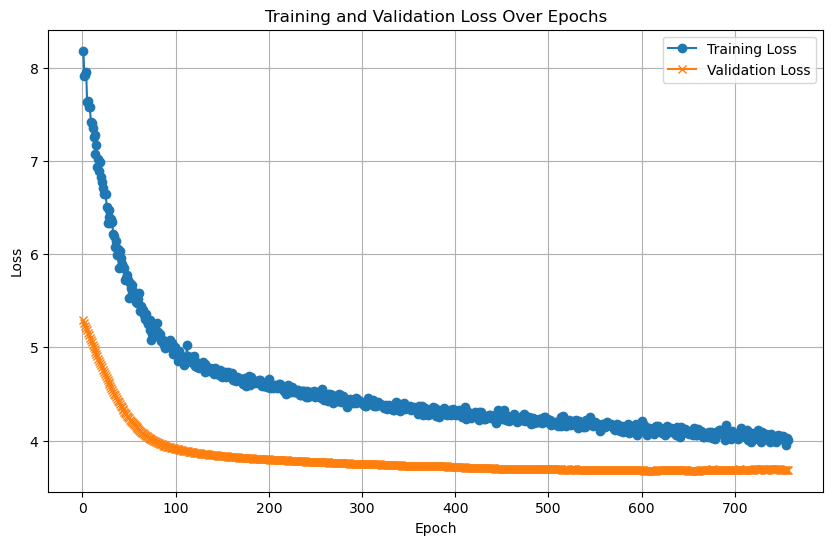

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 5.2790
Test Batch [20/20], Loss: 4.7376

Test Loss: 5.1399


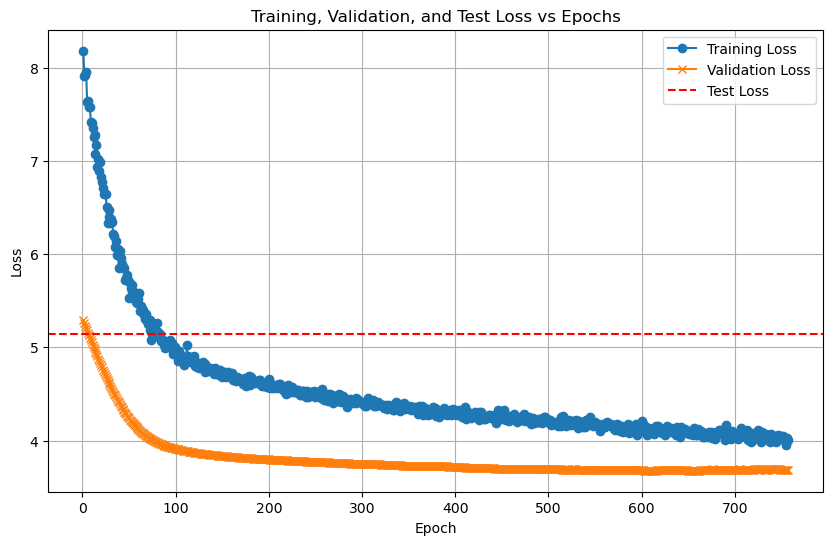

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 43.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.50      0.40      0.44         5
           5       0.36      0.80      0.50         5
           6       0.23      0.60      0.33         5
           7       0.38      0.60      0.46         5
           8       0.40      0.80      0.53         5
           9       0.00      0.00      0.00         5
          10       0.60      0.60      0.60         5
          11       0.57      0.80      0.67         5
          12       1.00      0.80      0.89         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6467  |  Val Loss: 2.6499
Validation loss improved from inf to 2.6499.
[Epoch 2/1000] Train Loss: 2.6323  |  Val Loss: 2.6369
Validation loss improved from 2.6499 to 2.6369.
[Epoch 3/1000] Train Loss: 2.6226  |  Val Loss: 2.6252
Validation loss improved from 2.6369 to 2.6252.
[Epoch 4/1000] Train Loss: 2.6110  |  Val Loss: 2.6156
Validation loss improved from 2.6252 to 2.6156.
[Epoch 5/1000] Train Loss: 2.6031  |  Val Loss: 2.6071
Validation loss improved from 2.6156 to 2.6071.
[Epoch 6/1000] Train Loss: 2.5939  |  Val Loss: 2.5994
Validation loss improved from 2.6071 to 2.5994.
[Epoch 7/1000] Train Loss: 2.5863  |  Val Loss: 2.5911
Validation loss improved from 2.5994 to 2.5911.
[Epoch 8/1000] Train Loss: 2.5794  |  Val Loss: 2.5833
Validation loss improved from 2.5911 to 2.5833.
[Epoch 9/1000] Train Loss: 2.5719  |  Val Loss: 2.5751
Validation loss improved from 2.5833 to 2.5751.
[Epoch 10/1000] Train Loss: 2.5646  |  Val Loss: 2.5669
Validation loss impr

[Epoch 19/1000] Train Loss: 2.4998  |  Val Loss: 2.4998
Validation loss improved from 2.5065 to 2.4998.
[Epoch 20/1000] Train Loss: 2.4937  |  Val Loss: 2.4934
Validation loss improved from 2.4998 to 2.4934.
[Epoch 21/1000] Train Loss: 2.4869  |  Val Loss: 2.4877
Validation loss improved from 2.4934 to 2.4877.
[Epoch 22/1000] Train Loss: 2.4799  |  Val Loss: 2.4823
Validation loss improved from 2.4877 to 2.4823.
[Epoch 23/1000] Train Loss: 2.4739  |  Val Loss: 2.4765
Validation loss improved from 2.4823 to 2.4765.
[Epoch 24/1000] Train Loss: 2.4672  |  Val Loss: 2.4713
Validation loss improved from 2.4765 to 2.4713.
[Epoch 25/1000] Train Loss: 2.4615  |  Val Loss: 2.4663
Validation loss improved from 2.4713 to 2.4663.
[Epoch 26/1000] Train Loss: 2.4561  |  Val Loss: 2.4615
Validation loss improved from 2.4663 to 2.4615.


[Epoch 27/1000] Train Loss: 2.4505  |  Val Loss: 2.4569
Validation loss improved from 2.4615 to 2.4569.
[Epoch 28/1000] Train Loss: 2.4459  |  Val Loss: 2.4525
Validation loss improved from 2.4569 to 2.4525.
[Epoch 29/1000] Train Loss: 2.4420  |  Val Loss: 2.4481
Validation loss improved from 2.4525 to 2.4481.
[Epoch 30/1000] Train Loss: 2.4378  |  Val Loss: 2.4443
Validation loss improved from 2.4481 to 2.4443.
[Epoch 31/1000] Train Loss: 2.4342  |  Val Loss: 2.4407
Validation loss improved from 2.4443 to 2.4407.
[Epoch 32/1000] Train Loss: 2.4303  |  Val Loss: 2.4370
Validation loss improved from 2.4407 to 2.4370.
[Epoch 33/1000] Train Loss: 2.4264  |  Val Loss: 2.4340
Validation loss improved from 2.4370 to 2.4340.
[Epoch 34/1000] Train Loss: 2.4231  |  Val Loss: 2.4308
Validation loss improved from 2.4340 to 2.4308.
[Epoch 35/1000] Train Loss: 2.4192  |  Val Loss: 2.4262
Validation loss improved from 2.4308 to 2.4262.
[Epoch 36/1000] Train Loss: 2.4146  |  Val Loss: 2.4225
Validati

[Epoch 51/1000] Train Loss: 2.3716  |  Val Loss: 2.3972
Validation loss improved from 2.3986 to 2.3972.
[Epoch 52/1000] Train Loss: 2.3695  |  Val Loss: 2.3962
Validation loss improved from 2.3972 to 2.3962.
[Epoch 53/1000] Train Loss: 2.3677  |  Val Loss: 2.3959
Validation loss improved from 2.3962 to 2.3959.
[Epoch 54/1000] Train Loss: 2.3663  |  Val Loss: 2.3959
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 2.3647  |  Val Loss: 2.3969
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 2.3634  |  Val Loss: 2.3982
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 57/1000] Train Loss: 2.3623  |  Val Loss: 2.3988
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 58/1000] Train Loss: 2.3608  |  Val Loss: 2.3989
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 59/1000] Train Loss: 2.3593  |  Val Loss: 2.3992
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 60/1000] Train Loss: 2.3582  |  Val Loss: 2.4000
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 61/1000] Train Loss: 2.3570  |  Val Loss: 2.4000
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 62/1000] Train Loss: 2.3554  |  Val Loss: 2.3990
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 63/1000] Train Loss: 2.3532  |  Val Loss: 2.3971
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 64/1000] Train Loss: 2.3505  |  Val Loss: 2.3947
Validation loss improved from 2.3959 to 2.3947.
[Epoch 65/1000] Train Loss: 2.3475  |  Val Loss: 2.3919
Validation loss improved from 2.3947 to 2.3919.
[Epoch 66/1000] Train Loss: 2.3448  |  Val Loss: 2.3894
Validation loss improved from 2.3919 to 2.3894.
[Epoch 67/1000] Train Loss:

[Epoch 79/1000] Train Loss: 2.3243  |  Val Loss: 2.3906
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 80/1000] Train Loss: 2.3225  |  Val Loss: 2.3918
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 81/1000] Train Loss: 2.3200  |  Val Loss: 2.3920
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 82/1000] Train Loss: 2.3189  |  Val Loss: 2.3907
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 83/1000] Train Loss: 2.3177  |  Val Loss: 2.3895
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 84/1000] Train Loss: 2.3168  |  Val Loss: 2.3888
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 85/1000] Train Loss: 2.3156  |  Val Loss: 2.3886
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 86/1000] Train Loss: 2.3143  |  Val Loss: 2.3888
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 87/1000] Train Loss: 2.3129  |  Val Loss: 2.3880
!! Validation loss did NOT improve !! Patience: 16/100
[Ep

[Epoch 89/1000] Train Loss: 2.3099  |  Val Loss: 2.3838
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 90/1000] Train Loss: 2.3085  |  Val Loss: 2.3828
Validation loss improved from 2.3833 to 2.3828.
[Epoch 91/1000] Train Loss: 2.3071  |  Val Loss: 2.3825
Validation loss improved from 2.3828 to 2.3825.
[Epoch 92/1000] Train Loss: 2.3058  |  Val Loss: 2.3829
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 93/1000] Train Loss: 2.3044  |  Val Loss: 2.3840
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 94/1000] Train Loss: 2.3028  |  Val Loss: 2.3850
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 95/1000] Train Loss: 2.3014  |  Val Loss: 2.3858
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 96/1000] Train Loss: 2.3003  |  Val Loss: 2.3867
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 97/1000] Train Loss: 2.2991  |  Val Loss: 2.3875
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 98/1000] Train

[Epoch 111/1000] Train Loss: 2.2830  |  Val Loss: 2.3910
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 112/1000] Train Loss: 2.2819  |  Val Loss: 2.3909
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 113/1000] Train Loss: 2.2809  |  Val Loss: 2.3909
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 114/1000] Train Loss: 2.2797  |  Val Loss: 2.3907
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 115/1000] Train Loss: 2.2792  |  Val Loss: 2.3902
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 116/1000] Train Loss: 2.2781  |  Val Loss: 2.3905
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 117/1000] Train Loss: 2.2788  |  Val Loss: 2.3910
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 118/1000] Train Loss: 2.2787  |  Val Loss: 2.3915
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 119/1000] Train Loss: 2.2779  |  Val Loss: 2.3919
!! Validation loss did NOT improve !! Patience:

[Epoch 120/1000] Train Loss: 2.2770  |  Val Loss: 2.3924
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 121/1000] Train Loss: 2.2754  |  Val Loss: 2.3928
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 122/1000] Train Loss: 2.2739  |  Val Loss: 2.3929
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 123/1000] Train Loss: 2.2721  |  Val Loss: 2.3928
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 124/1000] Train Loss: 2.2702  |  Val Loss: 2.3926
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 125/1000] Train Loss: 2.2686  |  Val Loss: 2.3922
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 126/1000] Train Loss: 2.2668  |  Val Loss: 2.3919
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 127/1000] Train Loss: 2.2658  |  Val Loss: 2.3921
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 128/1000] Train Loss: 2.2645  |  Val Loss: 2.3929
!! Validation loss did NOT improve !! Patience:

[Epoch 147/1000] Train Loss: 2.2402  |  Val Loss: 2.3903
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 148/1000] Train Loss: 2.2383  |  Val Loss: 2.3893
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 149/1000] Train Loss: 2.2371  |  Val Loss: 2.3897
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 150/1000] Train Loss: 2.2363  |  Val Loss: 2.3902
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 151/1000] Train Loss: 2.2352  |  Val Loss: 2.3907
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 152/1000] Train Loss: 2.2340  |  Val Loss: 2.3906
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 153/1000] Train Loss: 2.2326  |  Val Loss: 2.3900
!! Validation loss did NOT improve !! Patience: 62/100


[Epoch 154/1000] Train Loss: 2.2302  |  Val Loss: 2.3870
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 155/1000] Train Loss: 2.2279  |  Val Loss: 2.3816
Validation loss improved from 2.3825 to 2.3816.
[Epoch 156/1000] Train Loss: 2.2253  |  Val Loss: 2.3780
Validation loss improved from 2.3816 to 2.3780.
[Epoch 157/1000] Train Loss: 2.2247  |  Val Loss: 2.3760
Validation loss improved from 2.3780 to 2.3760.
[Epoch 158/1000] Train Loss: 2.2235  |  Val Loss: 2.3749
Validation loss improved from 2.3760 to 2.3749.
[Epoch 159/1000] Train Loss: 2.2225  |  Val Loss: 2.3745
Validation loss improved from 2.3749 to 2.3745.
[Epoch 160/1000] Train Loss: 2.2214  |  Val Loss: 2.3745
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 161/1000] Train Loss: 2.2199  |  Val Loss: 2.3747
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 162/1000] Train Loss: 2.2185  |  Val Loss: 2.3750
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 163/1000] Train Loss: 2

[Epoch 178/1000] Train Loss: 2.1960  |  Val Loss: 2.3856
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 179/1000] Train Loss: 2.1944  |  Val Loss: 2.3854
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 180/1000] Train Loss: 2.1928  |  Val Loss: 2.3851
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 181/1000] Train Loss: 2.1910  |  Val Loss: 2.3846
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 182/1000] Train Loss: 2.1891  |  Val Loss: 2.3821
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 183/1000] Train Loss: 2.1872  |  Val Loss: 2.3761
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 184/1000] Train Loss: 2.1857  |  Val Loss: 2.3717
Validation loss improved from 2.3745 to 2.3717.


[Epoch 185/1000] Train Loss: 2.1839  |  Val Loss: 2.3699
Validation loss improved from 2.3717 to 2.3699.
[Epoch 186/1000] Train Loss: 2.1818  |  Val Loss: 2.3694
Validation loss improved from 2.3699 to 2.3694.
[Epoch 187/1000] Train Loss: 2.1799  |  Val Loss: 2.3698
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 188/1000] Train Loss: 2.1781  |  Val Loss: 2.3705
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 189/1000] Train Loss: 2.1766  |  Val Loss: 2.3715
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 190/1000] Train Loss: 2.1751  |  Val Loss: 2.3722
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 191/1000] Train Loss: 2.1735  |  Val Loss: 2.3729
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 192/1000] Train Loss: 2.1724  |  Val Loss: 2.3719
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 193/1000] Train Loss: 2.1709  |  Val Loss: 2.3719
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 194/10

[Epoch 209/1000] Train Loss: 2.1496  |  Val Loss: 2.3690
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 210/1000] Train Loss: 2.1481  |  Val Loss: 2.3728
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 211/1000] Train Loss: 2.1465  |  Val Loss: 2.3767
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 212/1000] Train Loss: 2.1461  |  Val Loss: 2.3793
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 213/1000] Train Loss: 2.1456  |  Val Loss: 2.3812
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 214/1000] Train Loss: 2.1451  |  Val Loss: 2.3820
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 215/1000] Train Loss: 2.1437  |  Val Loss: 2.3816
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 216/1000] Train Loss: 2.1420  |  Val Loss: 2.3795
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 217/1000] Train Loss: 2.1391  |  Val Loss: 2.3750
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 218/1000] Train Loss: 2.1372  |  Val Loss: 2.3716
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 219/1000] Train Loss: 2.1385  |  Val Loss: 2.3710
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 220/1000] Train Loss: 2.1428  |  Val Loss: 2.3715
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 221/1000] Train Loss: 2.1470  |  Val Loss: 2.3715
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 222/1000] Train Loss: 2.1482  |  Val Loss: 2.3709
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 223/1000] Train Loss: 2.1461  |  Val Loss: 2.3695
!! Validation loss did NOT improve !! Patience: 15

[Epoch 237/1000] Train Loss: 2.1076  |  Val Loss: 2.3513
Validation loss improved from 2.3523 to 2.3513.
[Epoch 238/1000] Train Loss: 2.1061  |  Val Loss: 2.3511
Validation loss improved from 2.3513 to 2.3511.
[Epoch 239/1000] Train Loss: 2.1043  |  Val Loss: 2.3518
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 240/1000] Train Loss: 2.1022  |  Val Loss: 2.3530
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 241/1000] Train Loss: 2.0998  |  Val Loss: 2.3549
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 242/1000] Train Loss: 2.0976  |  Val Loss: 2.3571
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 243/1000] Train Loss: 2.0960  |  Val Loss: 2.3591
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 244/1000] Train Loss: 2.0946  |  Val Loss: 2.3620
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 245/1000] Train Loss: 2.0937  |  Val Loss: 2.3668
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 246/1000] Train Loss: 2.0934  |  Val Loss: 2.3705
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 247/1000] Train Loss: 2.0926  |  Val Loss: 2.3731
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 248/1000] Train Loss: 2.0918  |  Val Loss: 2.3765
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 249/1000] Train Loss: 2.0906  |  Val Loss: 2.3792
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 250/1000] Train Loss: 2.0892  |  Val Loss: 2.3805
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 251/1000] Train Loss: 2.0874  |  Val Loss: 2.3757
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 252/1000] Train Loss: 2.0847  |  Val Loss: 2.3628
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 271/1000] Train Loss: 2.0612  |  Val Loss: 2.3575
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 272/1000] Train Loss: 2.0603  |  Val Loss: 2.3576
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 273/1000] Train Loss: 2.0587  |  Val Loss: 2.3590
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 274/1000] Train Loss: 2.0541  |  Val Loss: 2.3627
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 275/1000] Train Loss: 2.0495  |  Val Loss: 2.3665
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 276/1000] Train Loss: 2.0472  |  Val Loss: 2.3703
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 277/1000] Train Loss: 2.0453  |  Val Loss: 2.3709
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 278/1000] Train Loss: 2.0434  |  Val Loss: 2.3670
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 279/1000] Train Loss: 2.0421  |  Val Loss: 2.3640
!! Validation loss did NOT improve !! Patience:

[Epoch 301/1000] Train Loss: 2.0061  |  Val Loss: 2.3624
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 302/1000] Train Loss: 2.0049  |  Val Loss: 2.3649
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 303/1000] Train Loss: 2.0043  |  Val Loss: 2.3671
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 304/1000] Train Loss: 2.0035  |  Val Loss: 2.3697
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 305/1000] Train Loss: 2.0021  |  Val Loss: 2.3725
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 306/1000] Train Loss: 2.0002  |  Val Loss: 2.3741
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 307/1000] Train Loss: 1.9985  |  Val Loss: 2.3754
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 308/1000] Train Loss: 1.9971  |  Val Loss: 2.3764
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 309/1000] Train Loss: 1.9953  |  Val Loss: 2.3763
!! Validation loss did NOT improve !! Patience: 

[Epoch 329/1000] Train Loss: 1.9655  |  Val Loss: 2.3681
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 330/1000] Train Loss: 1.9649  |  Val Loss: 2.3686
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 331/1000] Train Loss: 1.9637  |  Val Loss: 2.3684
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 332/1000] Train Loss: 1.9619  |  Val Loss: 2.3673
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 333/1000] Train Loss: 1.9599  |  Val Loss: 2.3656
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 334/1000] Train Loss: 1.9574  |  Val Loss: 2.3645
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 335/1000] Train Loss: 1.9550  |  Val Loss: 2.3631
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 336/1000] Train Loss: 1.9526  |  Val Loss: 2.3613
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 337/1000] Train Loss: 1.9502  |  Val Loss: 2.3604
!! Validation loss did NOT improve !! Patience:

[Epoch 360/1000] Train Loss: 1.9164  |  Val Loss: 2.3688
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 361/1000] Train Loss: 1.9143  |  Val Loss: 2.3666
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 362/1000] Train Loss: 1.9123  |  Val Loss: 2.3627
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 363/1000] Train Loss: 1.9098  |  Val Loss: 2.3552
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 364/1000] Train Loss: 1.9107  |  Val Loss: 2.3486
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 365/1000] Train Loss: 1.9128  |  Val Loss: 2.3465
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 366/1000] Train Loss: 1.9143  |  Val Loss: 2.3475
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 367/1000] Train Loss: 1.9115  |  Val Loss: 2.3498
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 368/1000] Train Loss: 1.9073  |  Val Loss: 2.3509
!! Validation loss did NOT improve !! Patience:

[Epoch 392/1000] Train Loss: 1.8715  |  Val Loss: 2.3714
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 392 !!
No improvement for 100 epochs.


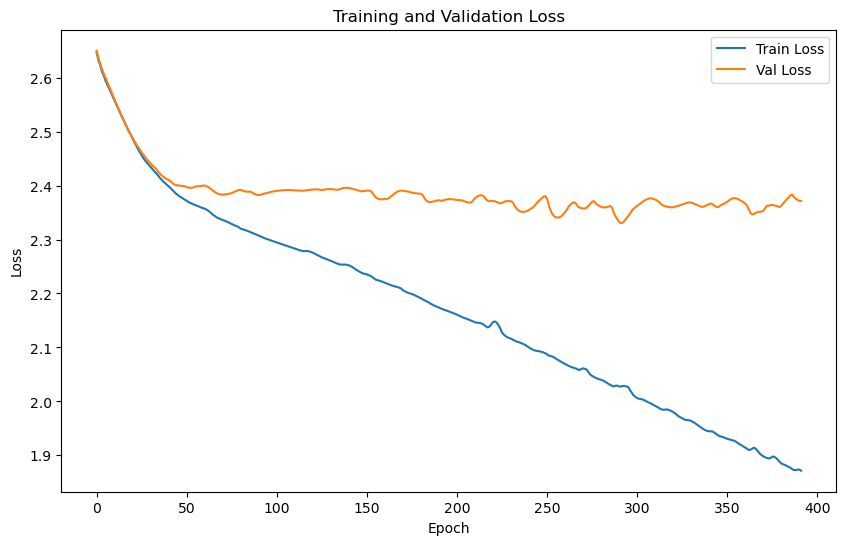

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.0290 | Test Accuracy: 32.58%


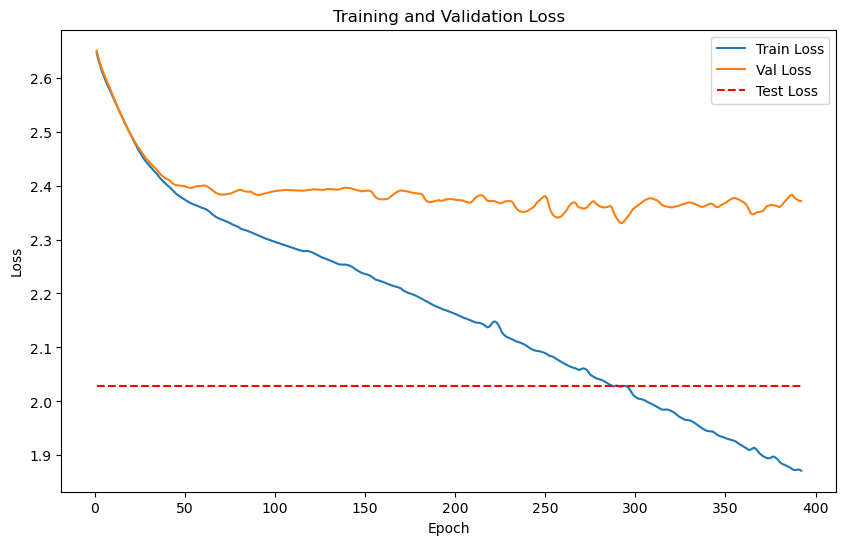

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5374
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5847
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5374, Avg Val Loss: 0.5423

Validation loss improved from inf to 0.5423. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 0.5392
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.5849
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5392, Avg Val Loss: 0.5424

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5377
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5847
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5377, Avg Val Loss: 0.5424

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5382
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5839
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5382, Avg Val Loss: 0.5420

Validation loss improved from 0.5423 to 0.5420. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5386
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5829
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5386, Avg Val Loss: 0.5414

Validation loss improved from 0.5420 to 0.5414. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5385
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5823


    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5385, Avg Val Loss: 0.5412

Validation loss improved from 0.5414 to 0.5412. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5383
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5822
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5383, Avg Val Loss: 0.5411

Validation loss improved from 0.5412 to 0.5411. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5349
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5823
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5349, Avg Val Loss: 0.5412

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.5299
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5820
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5299, Avg Val Loss: 0.5410

Validation loss improved from 0.5411 to 0.5410. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.5317
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.5813
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5317, Avg Val Loss: 0.5407

Validation loss improved from 0.5410 to 0.5407. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5373
LOG: Epoch [11/2000] - Validation


    Batch [1/2], Val Loss: 0.5802
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5373, Avg Val Loss: 0.5401

Validation loss improved from 0.5407 to 0.5401. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.5348
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5790
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5348, Avg Val Loss: 0.5395

Validation loss improved from 0.5401 to 0.5395. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5281
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5771
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5281, Avg Val Loss: 0.5385

Validation loss improved from 0.5395 to 0.5385. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5308
LOG: Epoch [14/2000] - Validation


    Batch [1/2], Val Loss: 0.5763
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5308, Avg Val Loss: 0.5382

Validation loss improved from 0.5385 to 0.5382. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/1], Train Loss: 0.5295
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5754
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5295, Avg Val Loss: 0.5377

Validation loss improved from 0.5382 to 0.5377. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.5296
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5747
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5296, Avg Val Loss: 0.5373

Validation loss improved from 0.5377 to 0.5373. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5252
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.5743
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5252, Avg Val Loss: 0.5372

Validation loss improved from 0.5373 to 0.5372. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 0.5256
LOG: Epoch [18/2000] - Validation


    Batch [1/2], Val Loss: 0.5739
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5256, Avg Val Loss: 0.5369

Validation loss improved from 0.5372 to 0.5369. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.5273
LOG: Epoch [19/2000] - Validation


    Batch [1/2], Val Loss: 0.5729
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5273, Avg Val Loss: 0.5364

Validation loss improved from 0.5369 to 0.5364. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5236
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5719
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5236, Avg Val Loss: 0.5359

Validation loss improved from 0.5364 to 0.5359. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.5239
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5714
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5239, Avg Val Loss: 0.5357

Validation loss improved from 0.5359 to 0.5357. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 0.5267
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5707
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5267, Avg Val Loss: 0.5353

Validation loss improved from 0.5357 to 0.5353. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.5260
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5691
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5260, Avg Val Loss: 0.5346

Validation loss improved from 0.5353 to 0.5346. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 0.5214
LOG: Epoch [24/2000] - Validation


    Batch [1/2], Val Loss: 0.5674
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5214, Avg Val Loss: 0.5337

Validation loss improved from 0.5346 to 0.5337. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.5202
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5658
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5202, Avg Val Loss: 0.5329

Validation loss improved from 0.5337 to 0.5329. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.5215
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5648
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5215, Avg Val Loss: 0.5324

Validation loss improved from 0.5329 to 0.5324. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5239
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.5638
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5239, Avg Val Loss: 0.5319

Validation loss improved from 0.5324 to 0.5319. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5222
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.5633
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5222, Avg Val Loss: 0.5317

Validation loss improved from 0.5319 to 0.5317. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5185
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5632
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5185, Avg Val Loss: 0.5316

Validation loss improved from 0.5317 to 0.5316. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.5196
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5625
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5196, Avg Val Loss: 0.5313

Validation loss improved from 0.5316 to 0.5313. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5197
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.5619
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5197, Avg Val Loss: 0.5310

Validation loss improved from 0.5313 to 0.5310. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.5180
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5614
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5180, Avg Val Loss: 0.5307

Validation loss improved from 0.5310 to 0.5307. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.5208
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5608
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5208, Avg Val Loss: 0.5304

Validation loss improved from 0.5307 to 0.5304. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.5167
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5602
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5167, Avg Val Loss: 0.5301

Validation loss improved from 0.5304 to 0.5301. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 0.5185
LOG: Epoch [35/2000] - Validation


    Batch [1/2], Val Loss: 0.5596
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5185, Avg Val Loss: 0.5298

Validation loss improved from 0.5301 to 0.5298. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.5133
LOG: Epoch [36/2000] - Validation


    Batch [1/2], Val Loss: 0.5588
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5133, Avg Val Loss: 0.5294

Validation loss improved from 0.5298 to 0.5294. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.5177
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5577
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5177, Avg Val Loss: 0.5289

Validation loss improved from 0.5294 to 0.5289. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.5128
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5567
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5128, Avg Val Loss: 0.5284

Validation loss improved from 0.5289 to 0.5284. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5163
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5557
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5163, Avg Val Loss: 0.5278

Validation loss improved from 0.5284 to 0.5278. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5142
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5547
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5273

Validation loss improved from 0.5278 to 0.5273. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5178
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5537
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5178, Avg Val Loss: 0.5268

Validation loss improved from 0.5273 to 0.5268. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.5127
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5527
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5127, Avg Val Loss: 0.5264

Validation loss improved from 0.5268 to 0.5264. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5158
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.5518
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5158, Avg Val Loss: 0.5259

Validation loss improved from 0.5264 to 0.5259. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.5142
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.5509
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5142, Avg Val Loss: 0.5254

Validation loss improved from 0.5259 to 0.5254. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5105
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5499
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5105, Avg Val Loss: 0.5249

Validation loss improved from 0.5254 to 0.5249. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.5148
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5489
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5148, Avg Val Loss: 0.5244

Validation loss improved from 0.5249 to 0.5244. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5130
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.5478
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5130, Avg Val Loss: 0.5239

Validation loss improved from 0.5244 to 0.5239. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.5131
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5469
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5131, Avg Val Loss: 0.5234

Validation loss improved from 0.5239 to 0.5234. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.5093
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5460
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5230

Validation loss improved from 0.5234 to 0.5230. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5112
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5451
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5112, Avg Val Loss: 0.5226

Validation loss improved from 0.5230 to 0.5226. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5108
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5443
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5108, Avg Val Loss: 0.5222

Validation loss improved from 0.5226 to 0.5222. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5114
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5435
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5114, Avg Val Loss: 0.5218

Validation loss improved from 0.5222 to 0.5218. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5108
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.5427
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5108, Avg Val Loss: 0.5213

Validation loss improved from 0.5218 to 0.5213. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5108
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5419
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5108, Avg Val Loss: 0.5210

Validation loss improved from 0.5213 to 0.5210. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.5088
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5412
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5088, Avg Val Loss: 0.5206

Validation loss improved from 0.5210 to 0.5206. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.5104
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.5406
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5104, Avg Val Loss: 0.5203

Validation loss improved from 0.5206 to 0.5203. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.5138
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5400
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5138, Avg Val Loss: 0.5200

Validation loss improved from 0.5203 to 0.5200. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.5069
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5395
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5069, Avg Val Loss: 0.5198

Validation loss improved from 0.5200 to 0.5198. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5390
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5195

Validation loss improved from 0.5198 to 0.5195. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.5116
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.5385
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5116, Avg Val Loss: 0.5193

Validation loss improved from 0.5195 to 0.5193. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5098
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5380
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5098, Avg Val Loss: 0.5190

Validation loss improved from 0.5193 to 0.5190. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.5092
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5376
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5092, Avg Val Loss: 0.5188

Validation loss improved from 0.5190 to 0.5188. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.5081
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.5371
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5081, Avg Val Loss: 0.5186

Validation loss improved from 0.5188 to 0.5186. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5048
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5367
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.5184

Validation loss improved from 0.5186 to 0.5184. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.5068
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5363
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5068, Avg Val Loss: 0.5182

Validation loss improved from 0.5184 to 0.5182. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [66/2000] - Validation


    Batch [1/2], Val Loss: 0.5360
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5180

Validation loss improved from 0.5182 to 0.5180. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.5357
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5178

Validation loss improved from 0.5180 to 0.5178. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5066
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5354
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.5177

Validation loss improved from 0.5178 to 0.5177. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.5048
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5351
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.5176

Validation loss improved from 0.5177 to 0.5176. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5348
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5174

Validation loss improved from 0.5176 to 0.5174. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.5059
LOG: Epoch [71/2000] - Validation


    Batch [1/2], Val Loss: 0.5346
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5059, Avg Val Loss: 0.5173

Validation loss improved from 0.5174 to 0.5173. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.5066
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.5343
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5066, Avg Val Loss: 0.5172

Validation loss improved from 0.5173 to 0.5172. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5081
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5341
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5081, Avg Val Loss: 0.5170

Validation loss improved from 0.5172 to 0.5170. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.5055
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5339
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5055, Avg Val Loss: 0.5169

Validation loss improved from 0.5170 to 0.5169. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.5034
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.5337
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5034, Avg Val Loss: 0.5168

Validation loss improved from 0.5169 to 0.5168. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5076
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.5335
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5076, Avg Val Loss: 0.5167

Validation loss improved from 0.5168 to 0.5167. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5333
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5166

Validation loss improved from 0.5167 to 0.5166. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.5075
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5331
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.5075, Avg Val Loss: 0.5165

Validation loss improved from 0.5166 to 0.5165. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.5329
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5165

Validation loss improved from 0.5165 to 0.5165. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5327
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5164

Validation loss improved from 0.5165 to 0.5164. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.5060
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5325
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5163

Validation loss improved from 0.5164 to 0.5163. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.5072
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5323
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5162

Validation loss improved from 0.5163 to 0.5162. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5322
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5161

Validation loss improved from 0.5162 to 0.5161. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.5037
LOG: Epoch [84/2000] - Validation


    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.5037, Avg Val Loss: 0.5160

Validation loss improved from 0.5161 to 0.5160. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.5071
LOG: Epoch [85/2000] - Validation


    Batch [1/2], Val Loss: 0.5319
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.5071, Avg Val Loss: 0.5160

Validation loss improved from 0.5160 to 0.5160. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 0.5068
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.5068, Avg Val Loss: 0.5159

Validation loss improved from 0.5160 to 0.5159. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.5318
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5159

Validation loss improved from 0.5159 to 0.5159. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [88/2000] - Validation


    Batch [1/2], Val Loss: 0.5317
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5158

Validation loss improved from 0.5159 to 0.5158. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.5053
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5315
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.5053, Avg Val Loss: 0.5158

Validation loss improved from 0.5158 to 0.5158. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.5093
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5314
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5157

Validation loss improved from 0.5158 to 0.5157. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.5025
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5311
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5156

Validation loss improved from 0.5157 to 0.5156. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.5064
LOG: Epoch [92/2000] - Validation


    Batch [1/2], Val Loss: 0.5309
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.5064, Avg Val Loss: 0.5155

Validation loss improved from 0.5156 to 0.5155. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.5051
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5307
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.5051, Avg Val Loss: 0.5153

Validation loss improved from 0.5155 to 0.5153. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5304
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5152

Validation loss improved from 0.5153 to 0.5152. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.5302
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5151

Validation loss improved from 0.5152 to 0.5151. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.5031
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5299
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.5031, Avg Val Loss: 0.5150

Validation loss improved from 0.5151 to 0.5150. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5149

Validation loss improved from 0.5150 to 0.5149. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.5295
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.5147

Validation loss improved from 0.5149 to 0.5147. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.5045
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.5293
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5146

Validation loss improved from 0.5147 to 0.5146. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5145

Validation loss improved from 0.5146 to 0.5145. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.5041
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.5041, Avg Val Loss: 0.5144

Validation loss improved from 0.5145 to 0.5144. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.5144

Validation loss improved from 0.5144 to 0.5144. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4988
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5286
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4988, Avg Val Loss: 0.5143

Validation loss improved from 0.5144 to 0.5143. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5143

Validation loss improved from 0.5143 to 0.5143. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5142

Validation loss improved from 0.5143 to 0.5142. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.5005
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5283
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.5005, Avg Val Loss: 0.5142

Validation loss improved from 0.5142 to 0.5142. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.5000
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4991
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4991, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.5022
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5284
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.5022, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4998
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5286
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5143

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.5029
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.5029, Avg Val Loss: 0.5143

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.5042
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.5042, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.5008
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.5008, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.5145

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.5289
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4997
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.5288
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5144

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.5287
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5143

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.5022
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.5285
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.5022, Avg Val Loss: 0.5142

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4995
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.5282
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4995, Avg Val Loss: 0.5141

Validation loss improved from 0.5142 to 0.5141. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.5278
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5139

Validation loss improved from 0.5141 to 0.5139. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5274
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.5137

Validation loss improved from 0.5139 to 0.5137. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5270
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5135

Validation loss improved from 0.5137 to 0.5135. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4983
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5133

Validation loss improved from 0.5135 to 0.5133. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 0.4942
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5263
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.5131

Validation loss improved from 0.5133 to 0.5131. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.5006
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.5259
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.5006, Avg Val Loss: 0.5129

Validation loss improved from 0.5131 to 0.5129. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4983
LOG: Epoch [128/2000] - Validation


    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5128

Validation loss improved from 0.5129 to 0.5128. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5127

Validation loss improved from 0.5128 to 0.5127. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4972
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5127

Validation loss improved from 0.5127 to 0.5127. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4963
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4963, Avg Val Loss: 0.5126

Validation loss improved from 0.5127 to 0.5126. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.4953
LOG: Epoch [132/2000] - Validation


    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4953, Avg Val Loss: 0.5126

Validation loss improved from 0.5126 to 0.5126. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4961
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.5252


    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4961, Avg Val Loss: 0.5126

Validation loss improved from 0.5126 to 0.5126. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [136/2000] - Validation


    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.4955
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4931
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4931, Avg Val Loss: 0.5128

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [139/2000] - Validation


    Batch [1/2], Val Loss: 0.5255
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4938
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4938, Avg Val Loss: 0.5127

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4921
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4921, Avg Val Loss: 0.5126

Validation loss improved from 0.5126 to 0.5126. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5126

Validation loss improved from 0.5126 to 0.5126. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4958
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4958, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4937
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.5253
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [148/2000] - Validation


    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.5126

Validation loss improved from 0.5126 to 0.5126. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [149/2000] - Validation


    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5125

Validation loss improved from 0.5126 to 0.5125. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4985
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.5247
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4985, Avg Val Loss: 0.5124

Validation loss improved from 0.5125 to 0.5124. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [151/2000] - Validation


    Batch [1/2], Val Loss: 0.5247
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5123

Validation loss improved from 0.5124 to 0.5123. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.4915
LOG: Epoch [152/2000] - Validation


    Batch [1/2], Val Loss: 0.5247
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.5123

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4964
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.5247
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4964, Avg Val Loss: 0.5123

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4923
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4927
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4924
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4924, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.5249
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.5250
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.5250
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4876
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.4908
LOG: Epoch [167/2000] - Validation


    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.4887
LOG: Epoch [168/2000] - Validation


    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4887, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4900
LOG: Epoch [169/2000] - Validation


    Batch [1/2], Val Loss: 0.5252
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.5251
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.5126

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.5250
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5125

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.5248
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.5124

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.5245
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5123

Validation loss improved from 0.5123 to 0.5123. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.5244
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.5122

Validation loss improved from 0.5123 to 0.5122. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4879
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.5241
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4879, Avg Val Loss: 0.5121

Validation loss improved from 0.5122 to 0.5121. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.4909
LOG: Epoch [176/2000] - Validation


    Batch [1/2], Val Loss: 0.5238
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4909, Avg Val Loss: 0.5119

Validation loss improved from 0.5121 to 0.5119. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.5236
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.5118

Validation loss improved from 0.5119 to 0.5118. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4884
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4884, Avg Val Loss: 0.5117

Validation loss improved from 0.5118 to 0.5117. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4844
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.5232
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.5116

Validation loss improved from 0.5117 to 0.5116. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.5115

Validation loss improved from 0.5116 to 0.5115. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.5227
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.5114

Validation loss improved from 0.5115 to 0.5114. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.5225
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5113

Validation loss improved from 0.5114 to 0.5113. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.5223
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.5112

Validation loss improved from 0.5113 to 0.5112. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.5221
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5110

Validation loss improved from 0.5112 to 0.5110. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4897
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.5218
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4897, Avg Val Loss: 0.5109

Validation loss improved from 0.5110 to 0.5109. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4875
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4875, Avg Val Loss: 0.5108

Validation loss improved from 0.5109 to 0.5108. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4868
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.5108

Validation loss improved from 0.5108 to 0.5108. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [188/2000] - Validation


    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.5107

Validation loss improved from 0.5108 to 0.5107. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.5108

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4852
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4852, Avg Val Loss: 0.5108

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.4827
LOG: Epoch [191/2000] - Validation


    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.5215
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.5214
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.4789
LOG: Epoch [194/2000] - Validation


    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.5107

Validation loss improved from 0.5107 to 0.5107. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.5106

Validation loss improved from 0.5107 to 0.5106. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.5106

Validation loss improved from 0.5106 to 0.5106. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [197/2000] - Validation


    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.5106

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5107

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4833
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.5107

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4862
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4862, Avg Val Loss: 0.5107

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.5213
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.5107

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.5106

Validation loss improved from 0.5106 to 0.5106. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [203/2000] - Validation


    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5106

Validation loss improved from 0.5106 to 0.5106. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.5211
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.5106

Validation loss improved from 0.5106 to 0.5106. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4785
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.5209
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4785, Avg Val Loss: 0.5105

Validation loss improved from 0.5106 to 0.5105. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4823
LOG: Epoch [206/2000] - Validation


    Batch [1/2], Val Loss: 0.5207
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4823, Avg Val Loss: 0.5103

Validation loss improved from 0.5105 to 0.5103. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.5204
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.5102

Validation loss improved from 0.5103 to 0.5102. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4835
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.5202
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4835, Avg Val Loss: 0.5101

Validation loss improved from 0.5102 to 0.5101. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.5199
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.5100

Validation loss improved from 0.5101 to 0.5100. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.4809
LOG: Epoch [210/2000] - Validation


    Batch [1/2], Val Loss: 0.5197
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4809, Avg Val Loss: 0.5098

Validation loss improved from 0.5100 to 0.5098. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.5097

Validation loss improved from 0.5098 to 0.5097. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4846
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.5097

Validation loss improved from 0.5097 to 0.5097. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.5097

Validation loss improved from 0.5097 to 0.5097. Saving model...
LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 0.4790
LOG: Epoch [214/2000] - Validation


    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.5097

Validation loss improved from 0.5097 to 0.5097. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4810
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.5194
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5097

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.5097

Validation loss improved from 0.5097 to 0.5097. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.5193
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.5096

Validation loss improved from 0.5097 to 0.5096. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.5191
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5096

Validation loss improved from 0.5096 to 0.5096. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.5189
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.5095

Validation loss improved from 0.5096 to 0.5095. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.5187
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.5093

Validation loss improved from 0.5095 to 0.5093. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4758
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.5185
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.5092

Validation loss improved from 0.5093 to 0.5092. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.5183
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.5092

Validation loss improved from 0.5092 to 0.5092. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.5181
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.5090

Validation loss improved from 0.5092 to 0.5090. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.5179
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.5090

Validation loss improved from 0.5090 to 0.5090. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [227/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.5089

Validation loss improved from 0.5090 to 0.5089. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.5089

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [229/2000] - Validation


    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4768
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4768, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.5178
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.5089

Validation loss improved from 0.5089 to 0.5089. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.5176
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5088

Validation loss improved from 0.5089 to 0.5088. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/1], Train Loss: 0.4770
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.5174
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4770, Avg Val Loss: 0.5087

Validation loss improved from 0.5088 to 0.5087. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.5085

Validation loss improved from 0.5087 to 0.5085. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [235/2000] - Validation


    Batch [1/2], Val Loss: 0.5166
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.5083

Validation loss improved from 0.5085 to 0.5083. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.5163
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.5082

Validation loss improved from 0.5083 to 0.5082. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.5160
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.5080

Validation loss improved from 0.5082 to 0.5080. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.5157
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.5078

Validation loss improved from 0.5080 to 0.5078. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [239/2000] - Validation


    Batch [1/2], Val Loss: 0.5154
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.5077

Validation loss improved from 0.5078 to 0.5077. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.5076

Validation loss improved from 0.5077 to 0.5076. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4703
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.5075

Validation loss improved from 0.5076 to 0.5075. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [242/2000] - Validation


    Batch [1/2], Val Loss: 0.5148
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.5074

Validation loss improved from 0.5075 to 0.5074. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 0.4762
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4762, Avg Val Loss: 0.5073

Validation loss improved from 0.5074 to 0.5073. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4741
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.5074

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4754
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.5073

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [248/2000] - Validation


    Batch [1/2], Val Loss: 0.5146
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.5073

Validation loss improved from 0.5073 to 0.5073. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.4743
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.5144
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4743, Avg Val Loss: 0.5072

Validation loss improved from 0.5073 to 0.5072. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.5143
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.5071

Validation loss improved from 0.5072 to 0.5071. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.5071

Validation loss improved from 0.5071 to 0.5071. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [252/2000] - Validation


    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.5071

Validation loss improved from 0.5071 to 0.5071. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.5070

Validation loss improved from 0.5071 to 0.5070. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.5070

Validation loss improved from 0.5070 to 0.5070. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4700
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.5069

Validation loss improved from 0.5070 to 0.5069. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.5070

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.5070

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.5070

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.5139
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [261/2000] - Validation


    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4685
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.5138
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4685, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [264/2000] - Validation


    Batch [1/2], Val Loss: 0.5137
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5069

Validation loss improved from 0.5069 to 0.5069. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.5068

Validation loss improved from 0.5069 to 0.5068. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.5067

Validation loss improved from 0.5068 to 0.5067. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4655
LOG: Epoch [267/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4655, Avg Val Loss: 0.5066

Validation loss improved from 0.5067 to 0.5066. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [268/2000] - Validation


    Batch [1/2], Val Loss: 0.5131
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.5065

Validation loss improved from 0.5066 to 0.5065. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000


Epoch [269/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.5064

Validation loss improved from 0.5065 to 0.5064. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.5062

Validation loss improved from 0.5064 to 0.5062. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.5121
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.5061

Validation loss improved from 0.5062 to 0.5061. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.5060

Validation loss improved from 0.5061 to 0.5060. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.5060

Validation loss improved from 0.5060 to 0.5060. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5060

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.5060

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.5122
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.5061

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.5124
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4707
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.5063

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5064

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4667
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.5133
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [286/2000] - Validation


    Batch [1/2], Val Loss: 0.5134
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.5067

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.4669
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.5132
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4669, Avg Val Loss: 0.5066

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4660
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4660, Avg Val Loss: 0.5065

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [289/2000] - Validation


    Batch [1/2], Val Loss: 0.5127
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.5064

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5062

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.5060

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [292/2000] - Validation


    Batch [1/2], Val Loss: 0.5117
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.5058

Validation loss improved from 0.5060 to 0.5058. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.4621
LOG: Epoch [293/2000] - Validation


    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.5057

Validation loss improved from 0.5058 to 0.5057. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5056

Validation loss improved from 0.5057 to 0.5056. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.5054

Validation loss improved from 0.5056 to 0.5054. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5053

Validation loss improved from 0.5054 to 0.5053. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [297/2000] - Validation


    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.5053

Validation loss improved from 0.5053 to 0.5053. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.5104
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5052

Validation loss improved from 0.5053 to 0.5052. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4656
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.5102
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.5051

Validation loss improved from 0.5052 to 0.5051. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4641
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.5099
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.5050

Validation loss improved from 0.5051 to 0.5050. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.5049

Validation loss improved from 0.5050 to 0.5049. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.5048

Validation loss improved from 0.5049 to 0.5048. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.5093
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.5046

Validation loss improved from 0.5048 to 0.5046. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5045

Validation loss improved from 0.5046 to 0.5045. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.5045

Validation loss improved from 0.5045 to 0.5045. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.5044

Validation loss improved from 0.5045 to 0.5044. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [307/2000] - Validation


    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.5043

Validation loss improved from 0.5044 to 0.5043. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.5043

Validation loss improved from 0.5043 to 0.5043. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.5043

Validation loss improved from 0.5043 to 0.5043. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4548
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [313/2000] - Validation


    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4575
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.5084
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.5042

Validation loss improved from 0.5043 to 0.5042. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [316/2000] - Validation


    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.5041

Validation loss improved from 0.5042 to 0.5041. Saving model...
LOG: Epoch [317/2000] - Training
    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.5040

Validation loss improved from 0.5041 to 0.5040. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.4559
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4559, Avg Val Loss: 0.5038

Validation loss improved from 0.5040 to 0.5038. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.5037

Validation loss improved from 0.5038 to 0.5037. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4580
LOG: Epoch [320/2000] - Validation


    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.5037

Validation loss improved from 0.5037 to 0.5037. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.5037

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.5037

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.5038

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [324/2000] - Validation


    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.5038

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.5040

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.5041

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4551
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4551, Avg Val Loss: 0.5042

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [330/2000] - Validation


    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.5088
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.5044

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5043

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.5041

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4608
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.5079
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4608, Avg Val Loss: 0.5039

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.5077
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.5038

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.5076
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.5038

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [337/2000] - Validation


    Batch [1/2], Val Loss: 0.5074
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.5037

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4525
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.5036

Validation loss improved from 0.5037 to 0.5036. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.5035

Validation loss improved from 0.5036 to 0.5035. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.5069
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.5035

Validation loss improved from 0.5035 to 0.5035. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4511
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.5036

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.5036

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.5035

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.5034

Validation loss improved from 0.5035 to 0.5034. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [348/2000] - Validation


    Batch [1/2], Val Loss: 0.5066
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.5033

Validation loss improved from 0.5034 to 0.5033. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.5064
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.5032

Validation loss improved from 0.5033 to 0.5032. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4527
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.5032

Validation loss improved from 0.5032 to 0.5032. Saving model...
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [351/2000] - Validation


    Batch [1/2], Val Loss: 0.5062
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.5031

Validation loss improved from 0.5031 to 0.5031. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.5031

Validation loss improved from 0.5031 to 0.5031. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [355/2000] - Validation


    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.5061
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.5030

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.5060
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5030

Validation loss improved from 0.5030 to 0.5030. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [358/2000] - Validation


    Batch [1/2], Val Loss: 0.5058
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.5029

Validation loss improved from 0.5030 to 0.5029. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [359/2000] - Validation


    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5028

Validation loss improved from 0.5029 to 0.5028. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.5027

Validation loss improved from 0.5028 to 0.5027. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.5053
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.5027

Validation loss improved from 0.5027 to 0.5027. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [362/2000] - Validation


    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.5026

Validation loss improved from 0.5027 to 0.5026. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.5051
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.5026

Validation loss improved from 0.5026 to 0.5026. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.5025

Validation loss improved from 0.5026 to 0.5025. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5024

Validation loss improved from 0.5025 to 0.5024. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.5047
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.5023

Validation loss improved from 0.5024 to 0.5023. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4519
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.5045
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4519, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [368/2000] - Validation


    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.5022

Validation loss improved from 0.5023 to 0.5022. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.5044
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5022

Validation loss improved from 0.5022 to 0.5022. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.5021

Validation loss improved from 0.5022 to 0.5021. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.5041
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.5020

Validation loss improved from 0.5021 to 0.5020. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.5037


    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5019

Validation loss improved from 0.5020 to 0.5019. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.5034
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.5017

Validation loss improved from 0.5019 to 0.5017. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.5016

Validation loss improved from 0.5017 to 0.5016. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4474
LOG: Epoch [375/2000] - Validation


    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.5015

Validation loss improved from 0.5016 to 0.5015. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.5015

Validation loss improved from 0.5015 to 0.5015. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.5014

Validation loss improved from 0.5015 to 0.5014. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.5015

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.5031
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.5015

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [381/2000] - Validation


    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [382/2000] - Training
    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.5016

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.5015

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.5029
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.5014

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.5014

Validation loss improved from 0.5014 to 0.5014. Saving model...
LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [386/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.5013

Validation loss improved from 0.5014 to 0.5013. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [387/2000] - Validation


    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.5014

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.5013

Validation loss improved from 0.5013 to 0.5013. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.5012

Validation loss improved from 0.5013 to 0.5012. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.5012

Validation loss improved from 0.5012 to 0.5012. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.5011

Validation loss improved from 0.5012 to 0.5011. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [394/2000] - Validation


    Batch [1/2], Val Loss: 0.5023
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [395/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [396/2000] - Validation


    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [397/2000] - Validation


    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.5013

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.5013

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [400/2000] - Validation


    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.5013

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [401/2000] - Validation


    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.5013

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.5026
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.5013

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4439
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4439, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [404/2000] - Validation


    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.5011

Validation loss improved from 0.5011 to 0.5011. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [405/2000] - Validation


    Batch [1/2], Val Loss: 0.5020
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.5010

Validation loss improved from 0.5011 to 0.5010. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.5009

Validation loss improved from 0.5010 to 0.5009. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.5008

Validation loss improved from 0.5009 to 0.5008. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [408/2000] - Validation


    Batch [1/2], Val Loss: 0.5014
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.5007

Validation loss improved from 0.5008 to 0.5007. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [409/2000] - Validation


    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.5006

Validation loss improved from 0.5007 to 0.5006. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.5011
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.5005

Validation loss improved from 0.5006 to 0.5005. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.5013
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.5009

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [416/2000] - Validation


    Batch [1/2], Val Loss: 0.5017
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.5008

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.5015
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.5007

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.5006

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.5009
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.5005

Validation loss improved from 0.5005 to 0.5005. Saving model...
LOG: Epoch [420/2000] - Training
    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [420/2000] - Validation


    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.5003

Validation loss improved from 0.5005 to 0.5003. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.5002
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.5001

Validation loss improved from 0.5003 to 0.5001. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.4999

Validation loss improved from 0.5001 to 0.4999. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [423/2000] - Validation


    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.4998

Validation loss improved from 0.4999 to 0.4998. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4996

Validation loss improved from 0.4998 to 0.4996. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4995

Validation loss improved from 0.4996 to 0.4995. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4994

Validation loss improved from 0.4995 to 0.4994. Saving model...
LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [427/2000] - Validation


    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.4994

Validation loss improved from 0.4994 to 0.4994. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [428/2000] - Validation


    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.4994

Validation loss improved from 0.4994 to 0.4994. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [429/2000] - Validation


    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [430/2000] - Validation


    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [433/2000] - Validation


    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [434/2000] - Validation


    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [437/2000] - Validation


    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [440/2000] - Validation


    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.4994

Validation loss improved from 0.4994 to 0.4994. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4993

Validation loss improved from 0.4994 to 0.4993. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.4992

Validation loss improved from 0.4993 to 0.4992. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [443/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [446/2000] - Validation


    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [447/2000] - Validation


    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [451/2000] - Validation


    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.4998

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.5002

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.5003

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.5003

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [460/2000] - Validation


    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.5002

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.5000

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.5000

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [467/2000] - Validation


    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.5002

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.5003

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [470/2000] - Training
    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [470/2000] - Validation


    Batch [1/2], Val Loss: 0.5008
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [471/2000] - Validation


    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [472/2000] - Validation


    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [473/2000] - Validation


    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.5004

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.5003

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.5003

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [476/2000] - Validation


    Batch [1/2], Val Loss: 0.5006
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.5003

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.5003

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.5005
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.5002

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [479/2000] - Validation


    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.5002

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.5003
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.5002
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [482/2000] - Training
    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [482/2000] - Validation


    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.5001

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.5000

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.5000
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.5000

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [485/2000] - Validation


    Batch [1/2], Val Loss: 0.4999
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4998
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.4999

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [488/2000] - Validation


    Batch [1/2], Val Loss: 0.4997
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.4998

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [489/2000] - Validation


    Batch [1/2], Val Loss: 0.4996
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.4998

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [490/2000] - Training
    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [490/2000] - Validation


    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4994
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4993
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4997

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [494/2000] - Validation


    Batch [1/2], Val Loss: 0.4992
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.4996

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [498/2000] - Validation


    Batch [1/2], Val Loss: 0.4989
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [499/2000] - Validation


    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [503/2000] - Validation


    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [506/2000] - Validation


    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [507/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4986
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.4993

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [512/2000] - Validation


    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [515/2000] - Validation


    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [516/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [517/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [521/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [522/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [526/2000] - Training
    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [526/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [529/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.4992

Validation loss improved from 0.4992 to 0.4992. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [533/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [534/2000] - Training
    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [534/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [535/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [536/2000] - Training
    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [536/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [537/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [541/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [544/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [547/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [550/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [553/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [554/2000] - Training
    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [556/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [560/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [561/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [562/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [563/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [566/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [567/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [567/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [568/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [568/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [569/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [570/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [571/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [572/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [573/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [574/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [574/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [575/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [576/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [577/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [577/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [578/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [579/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [580/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [580/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [581/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [582/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [583/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [584/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [584/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [585/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [586/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [587/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [587/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [588/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [589/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.4317
LOG: Epoch [590/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [590/2000], Avg Train Loss: 0.4317, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [591/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [592/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [593/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [593/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [594/2000] - Training
    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000


Epoch [594/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [595/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [596/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [597/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [597/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [598/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [599/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [600/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [600/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [601/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [602/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [603/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [603/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [604/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [604/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4984


    Batch [2/2], Val Loss: 0.5000
Epoch [605/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [606/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [607/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [608/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [608/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.4252
LOG: Epoch [609/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [609/2000], Avg Train Loss: 0.4252, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [610/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [611/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [612/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [612/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.4325
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [613/2000], Avg Train Loss: 0.4325, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [614/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [615/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [616/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [616/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [617/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [618/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [619/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [620/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [621/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [621/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [622/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [623/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [624/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [624/2000] - Validation


    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [624/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [625/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [626/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [627/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [628/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4984
    Batch [2/2], Val Loss: 0.5000
Epoch [629/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.4992

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 629!!
No improvement for 100 epochs


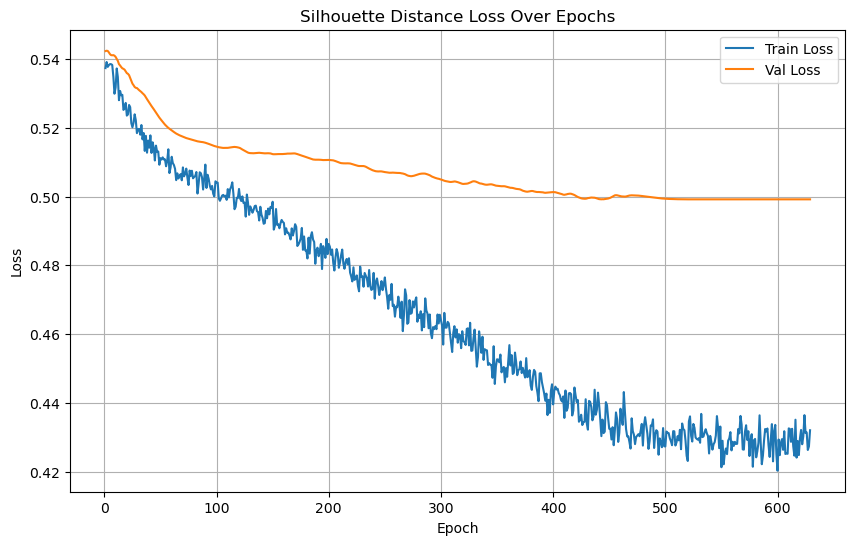

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/79], Loss: 0.3304


Test Batch [20/79], Loss: 0.1054
Test Batch [30/79], Loss: 0.3517
Test Batch [40/79], Loss: 0.2730
Test Batch [50/79], Loss: 0.2950
Test Batch [60/79], Loss: 0.4021
Test Batch [70/79], Loss: 0.2529



Test Loss: 0.3235


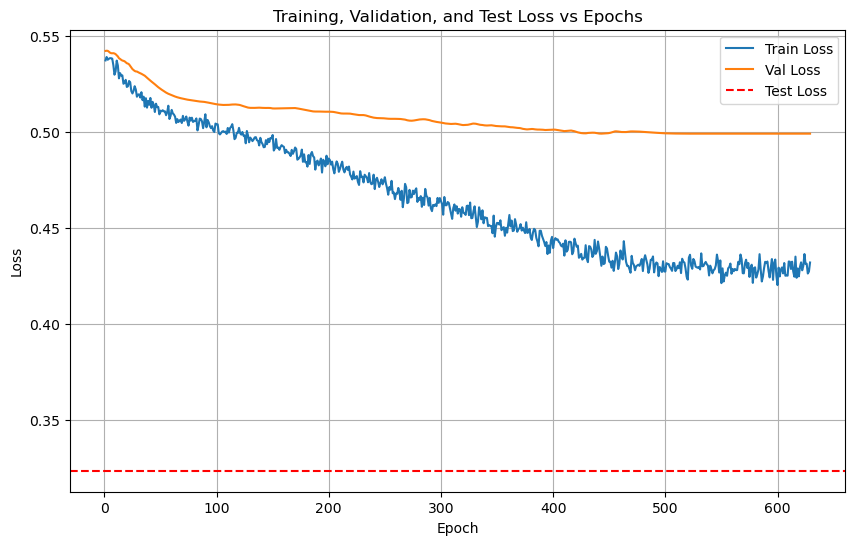

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/79 for test dataset.


  Processed batch 20/79 for test dataset.


  Processed batch 30/79 for test dataset.
  Processed batch 40/79 for test dataset.
  Processed batch 50/79 for test dataset.


  Processed batch 60/79 for test dataset.


  Processed batch 70/79 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 47.69%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.50      0.20      0.29         5
           2       0.25      0.20      0.22         5
           3       0.00      0.00      0.00         5
           4       0.57      0.80      0.67         5
           5       0.36      0.80      0.50         5
           6       0.43      0.60      0.50         5
           7       0.25      0.40      0.31         5
           8       0.57      0.80      0.67         5
           9       0.00      0.00      0.00         5
          10       0.83      1.00      0.91         5
          11       0.57      0.80      0.67         5
          12       1.00      0.40      0.57         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6746  |  Val Loss: 2.7084
Validation loss improved from inf to 2.7084.
[Epoch 2/1000] Train Loss: 2.6543  |  Val Loss: 2.6909
Validation loss improved from 2.7084 to 2.6909.
[Epoch 3/1000] Train Loss: 2.6394  |  Val Loss: 2.6733
Validation loss improved from 2.6909 to 2.6733.
[Epoch 4/1000] Train Loss: 2.6224  |  Val Loss: 2.6562
Validation loss improved from 2.6733 to 2.6562.
[Epoch 5/1000] Train Loss: 2.6087  |  Val Loss: 2.6398
Validation loss improved from 2.6562 to 2.6398.
[Epoch 6/1000] Train Loss: 2.5937  |  Val Loss: 2.6255
Validation loss improved from 2.6398 to 2.6255.
[Epoch 7/1000] Train Loss: 2.5793  |  Val Loss: 2.6128
Validation loss improved from 2.6255 to 2.6128.
[Epoch 8/1000] Train Loss: 2.5660  |  Val Loss: 2.6014
Validation loss improved from 2.6128 to 2.6014.
[Epoch 9/1000] Train Loss: 2.5536  |  Val Loss: 2.5909
Validation loss improved from 2.6014 to 2.5909.
[Epoch 10/1000] Train Loss: 2.5424  |  Val Loss: 2.5815
Validation loss impr

[Epoch 22/1000] Train Loss: 2.4389  |  Val Loss: 2.5023
Validation loss improved from 2.5060 to 2.5023.
[Epoch 23/1000] Train Loss: 2.4323  |  Val Loss: 2.4992
Validation loss improved from 2.5023 to 2.4992.
[Epoch 24/1000] Train Loss: 2.4261  |  Val Loss: 2.4964
Validation loss improved from 2.4992 to 2.4964.
[Epoch 25/1000] Train Loss: 2.4203  |  Val Loss: 2.4940
Validation loss improved from 2.4964 to 2.4940.
[Epoch 26/1000] Train Loss: 2.4150  |  Val Loss: 2.4919
Validation loss improved from 2.4940 to 2.4919.
[Epoch 27/1000] Train Loss: 2.4100  |  Val Loss: 2.4901
Validation loss improved from 2.4919 to 2.4901.


[Epoch 28/1000] Train Loss: 2.4053  |  Val Loss: 2.4885
Validation loss improved from 2.4901 to 2.4885.
[Epoch 29/1000] Train Loss: 2.4008  |  Val Loss: 2.4870
Validation loss improved from 2.4885 to 2.4870.
[Epoch 30/1000] Train Loss: 2.3963  |  Val Loss: 2.4857
Validation loss improved from 2.4870 to 2.4857.
[Epoch 31/1000] Train Loss: 2.3921  |  Val Loss: 2.4844
Validation loss improved from 2.4857 to 2.4844.
[Epoch 32/1000] Train Loss: 2.3881  |  Val Loss: 2.4832
Validation loss improved from 2.4844 to 2.4832.
[Epoch 33/1000] Train Loss: 2.3832  |  Val Loss: 2.4820
Validation loss improved from 2.4832 to 2.4820.
[Epoch 34/1000] Train Loss: 2.3786  |  Val Loss: 2.4808
Validation loss improved from 2.4820 to 2.4808.
[Epoch 35/1000] Train Loss: 2.3741  |  Val Loss: 2.4797
Validation loss improved from 2.4808 to 2.4797.
[Epoch 36/1000] Train Loss: 2.3697  |  Val Loss: 2.4786
Validation loss improved from 2.4797 to 2.4786.
[Epoch 37/1000] Train Loss: 2.3655  |  Val Loss: 2.4775
Validati

[Epoch 55/1000] Train Loss: 2.2864  |  Val Loss: 2.4740
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 56/1000] Train Loss: 2.2826  |  Val Loss: 2.4749
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 57/1000] Train Loss: 2.2786  |  Val Loss: 2.4761
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 58/1000] Train Loss: 2.2750  |  Val Loss: 2.4773
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 59/1000] Train Loss: 2.2714  |  Val Loss: 2.4785
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 60/1000] Train Loss: 2.2678  |  Val Loss: 2.4795
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 61/1000] Train Loss: 2.2643  |  Val Loss: 2.4804
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 62/1000] Train Loss: 2.2608  |  Val Loss: 2.4811
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 63/1000] Train Loss: 2.2566  |  Val Loss: 2.4817
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 64/1000] Train Loss: 2.2530  |  Val Loss: 2.4823
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 65/1000] Train Loss: 2.2486  |  Val Loss: 2.4831
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 66/1000] Train Loss: 2.2445  |  Val Loss: 2.4837
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 67/1000] Train Loss: 2.2408  |  Val Loss: 2.4843
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 68/1000] Train Loss: 2.2369  |  Val Loss: 2.4850
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 69/1000] Train Loss: 2.2334  |  Val Loss: 2.4862
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 70/1000] Train Loss: 2.2299  |  Val Loss: 2.4882
!! Validation loss did NOT improve !! Patience: 20/100
[

[Epoch 86/1000] Train Loss: 2.1795  |  Val Loss: 2.5033
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 87/1000] Train Loss: 2.1763  |  Val Loss: 2.5035
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 88/1000] Train Loss: 2.1728  |  Val Loss: 2.5037
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 89/1000] Train Loss: 2.1697  |  Val Loss: 2.5041
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 90/1000] Train Loss: 2.1671  |  Val Loss: 2.5047
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 91/1000] Train Loss: 2.1644  |  Val Loss: 2.5054
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 92/1000] Train Loss: 2.1619  |  Val Loss: 2.5062
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 93/1000] Train Loss: 2.1592  |  Val Loss: 2.5067
!! Validation loss did NOT improve !! Patience: 43/100


[Epoch 94/1000] Train Loss: 2.1562  |  Val Loss: 2.5068
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 95/1000] Train Loss: 2.1532  |  Val Loss: 2.5068
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 96/1000] Train Loss: 2.1501  |  Val Loss: 2.5069
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 97/1000] Train Loss: 2.1472  |  Val Loss: 2.5073
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 98/1000] Train Loss: 2.1446  |  Val Loss: 2.5076
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 99/1000] Train Loss: 2.1420  |  Val Loss: 2.5090
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 100/1000] Train Loss: 2.1394  |  Val Loss: 2.5122
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 101/1000] Train Loss: 2.1365  |  Val Loss: 2.5157
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 102/1000] Train Loss: 2.1337  |  Val Loss: 2.5203
!! Validation loss did NOT improve !! Patience: 52/10

[Epoch 121/1000] Train Loss: 2.0872  |  Val Loss: 2.5495
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 122/1000] Train Loss: 2.0851  |  Val Loss: 2.5517
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 123/1000] Train Loss: 2.0829  |  Val Loss: 2.5531
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 124/1000] Train Loss: 2.0808  |  Val Loss: 2.5538
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 125/1000] Train Loss: 2.0789  |  Val Loss: 2.5543
!! Validation loss did NOT improve !! Patience: 75/100


[Epoch 126/1000] Train Loss: 2.0769  |  Val Loss: 2.5544
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 127/1000] Train Loss: 2.0748  |  Val Loss: 2.5555
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 128/1000] Train Loss: 2.0726  |  Val Loss: 2.5584
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 129/1000] Train Loss: 2.0704  |  Val Loss: 2.5604
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 130/1000] Train Loss: 2.0684  |  Val Loss: 2.5619
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 131/1000] Train Loss: 2.0662  |  Val Loss: 2.5630
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 132/1000] Train Loss: 2.0643  |  Val Loss: 2.5640
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 133/1000] Train Loss: 2.0624  |  Val Loss: 2.5649
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 134/1000] Train Loss: 2.0605  |  Val Loss: 2.5650
!! Validation loss did NOT improve !! Patience:

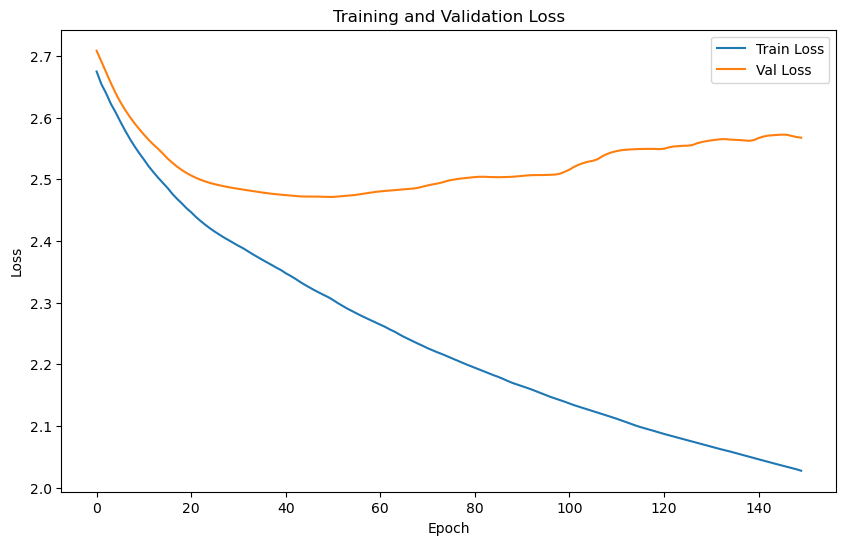

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.3430 | Test Accuracy: 36.54%


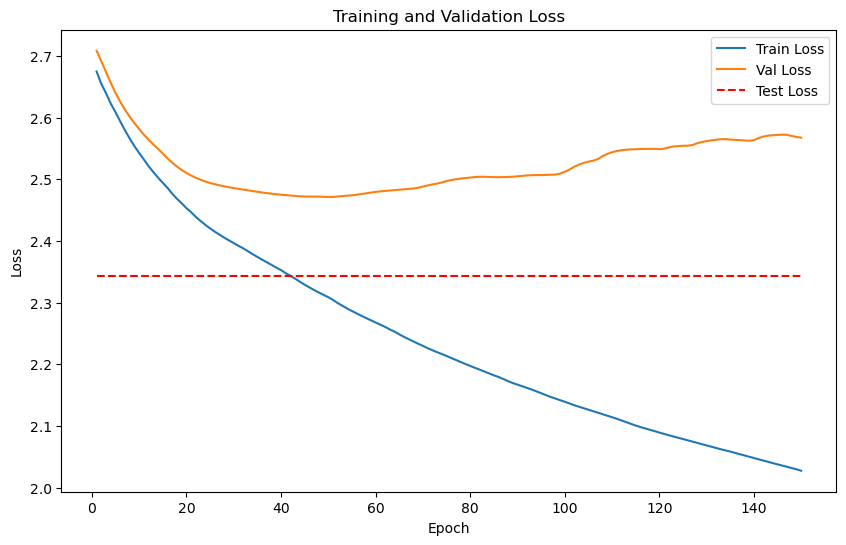

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


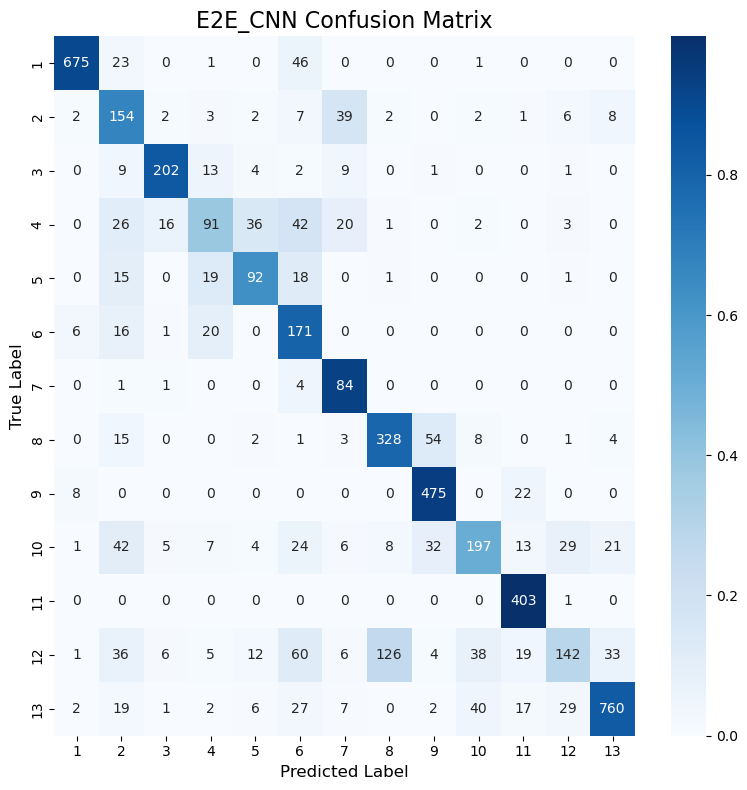

Classification Accuracy: 75.24%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


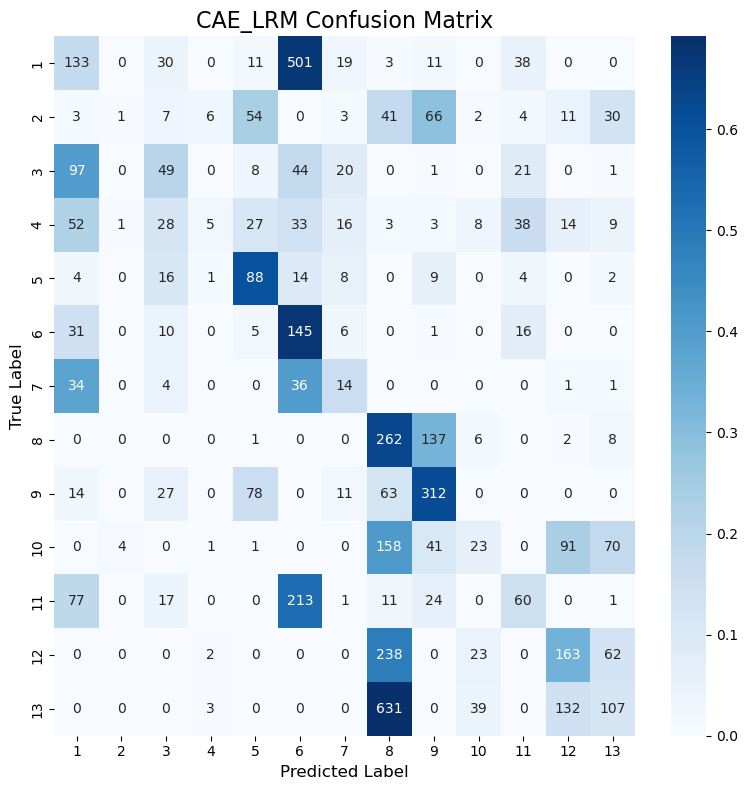

Classification Accuracy: 27.15%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


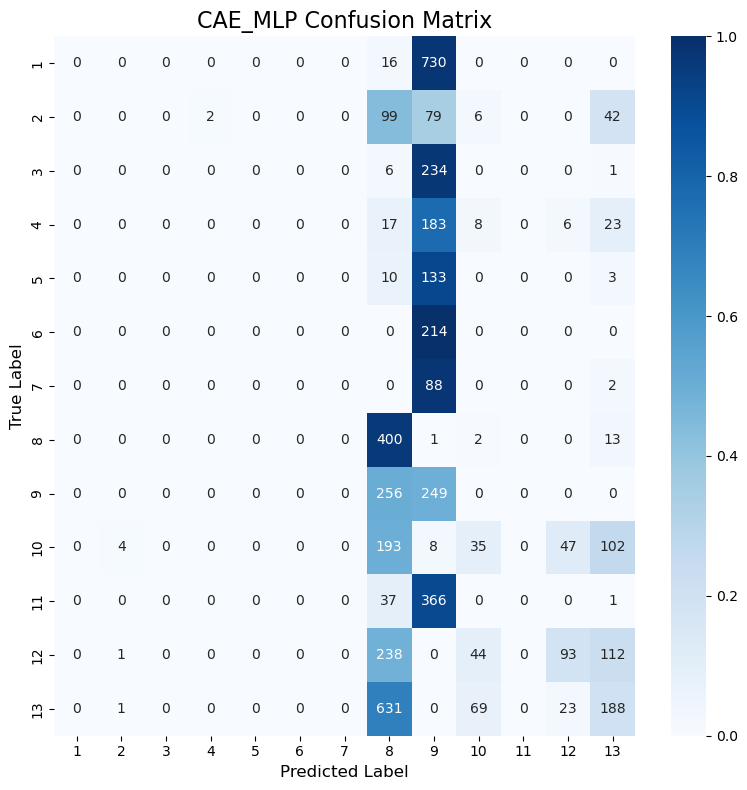

Classification Accuracy: 19.24%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


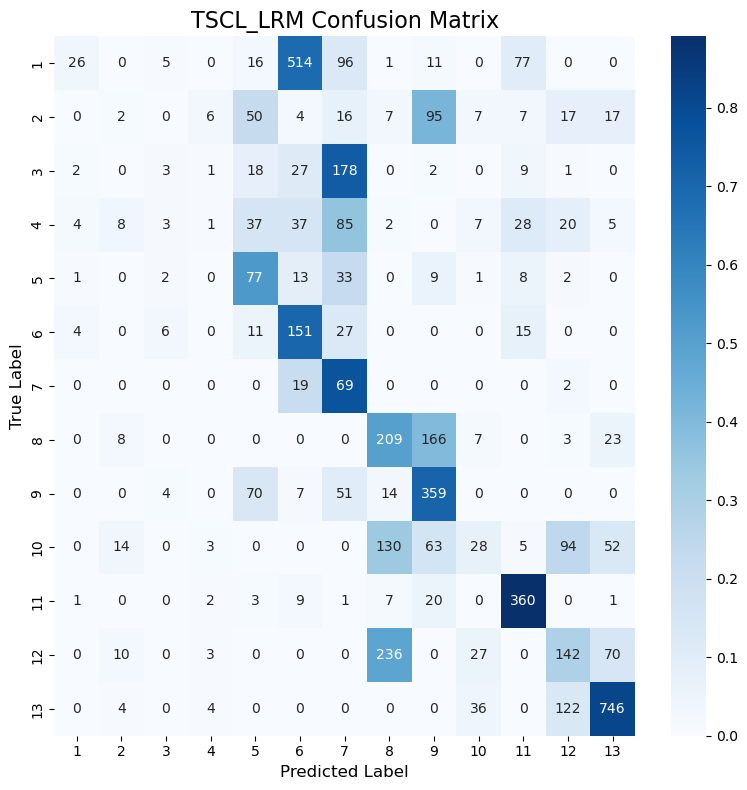

Classification Accuracy: 43.32%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


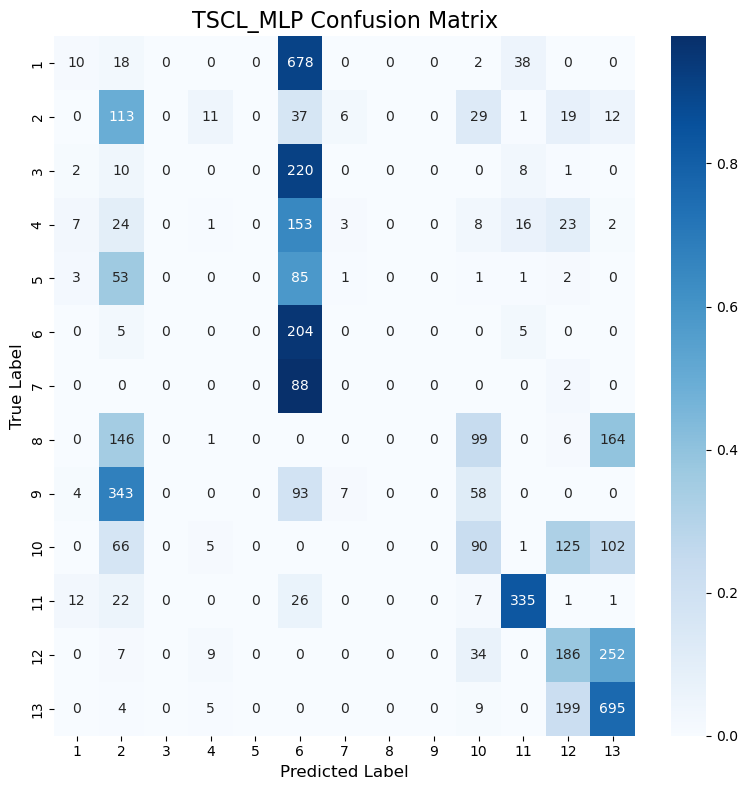

Classification Accuracy: 32.58%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


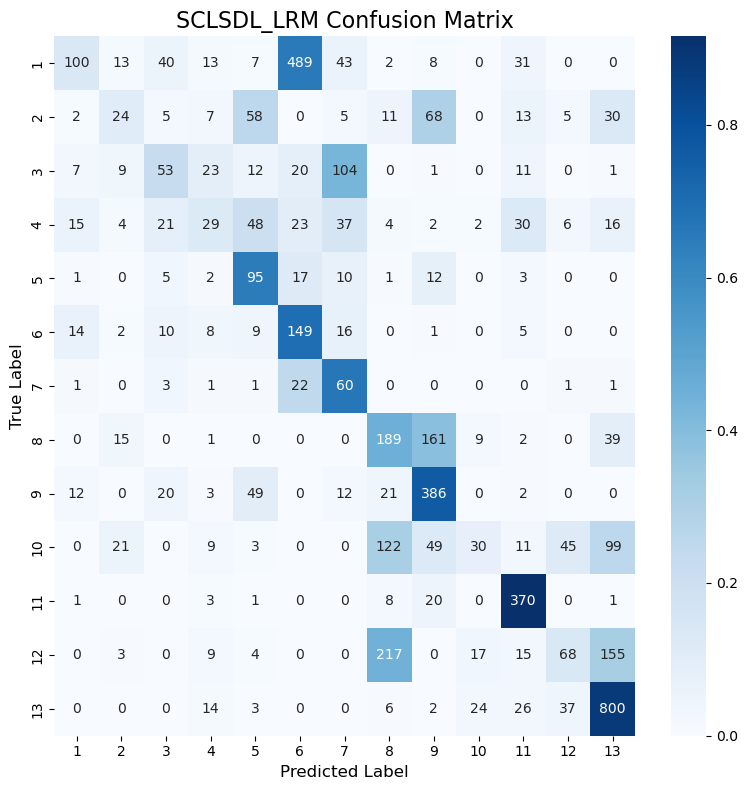

Classification Accuracy: 46.91%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


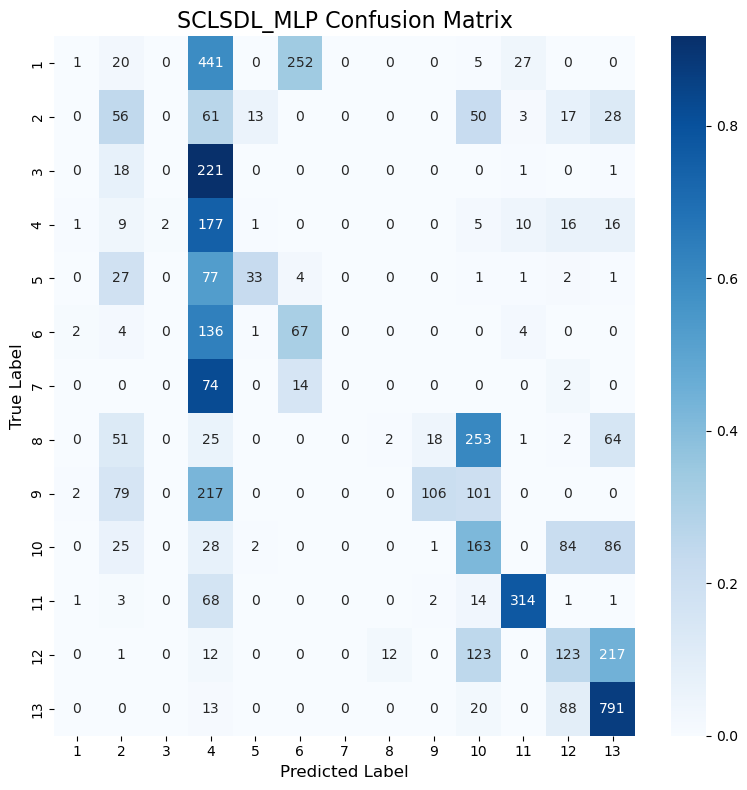

Classification Accuracy: 36.54%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          75.24
1    LRM (CAE)          27.15
2    MLP (CAE)          19.24
3     TSCL LRM          43.32
4     TSCL MLP          32.58
5  SCL_SDL LRM          46.91
6  SCL_SDL MLP          36.54

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          75.24
5  SCL_SDL LRM          46.91
3     TSCL LRM          43.32
6  SCL_SDL MLP          36.54
4     TSCL MLP          32.58
1    LRM (CAE)          27.15
2    MLP (CAE)          19.24
